# Homework 2
## Josias Moukpe
### 10-2-2023

### Instructions

Submit **one** Python notebook file for grading. Your file must include **text explanations** of your work, **well-commented code**, and the **outputs** from your code.

### Problems

#### Gradients

1. [10 points] Consider a single neuron with 3 inputs and PReLU activation function. Find the mathematical formula for the gradient of the activated output with respect to its incoming weights **and** the learnable PReLU parameter.

A single neuron with 3 inputs and PReLU activation function is formalized as follows:
$$ z = w_1x_1 + w_2x_2 + w_3x_3 + w_0 $$ where $w_0$ is the bias and $w_i$ are the weights of the $i$-th input $x_i$. the output $y$ after activation is then given by:
$$ y = f(z) = \begin{cases} az, & \text{ if } z < 0 \\ z, & \text{ if } z \geq 0 \end{cases} $$
where $a$ is a learnable parameter, $z$ is the net output of the neuron and $y$ is the output prediction.
The gradient of the output $y$ with respect to the weights are given by:
$$ \frac{\partial y}{\partial w_i} = \frac{\partial f(z)}{\partial w_i} = \frac{\partial f(z)}{\partial z} \cdot \frac{\partial z}{\partial w_i} $$ 
Considering $x_0 = 1$, then we know $$ \frac{\partial z}{\partial w_i} = x_i $$  and 
$$ \frac{\partial f(z)}{\partial z} = \begin{cases} a, & \text{ if } z < 0 \\ 1, & \text{ if } z \geq 0 \end{cases} $$
Therefore, the gradients of $ y $ with respect to $ w_0, w_1, w_2, $ and $ w_3 $ are given by:
$$ \frac{\partial y}{\partial w_i} = \begin{cases} ax_i, & \text{ if } z < 0 \\ x_i, & \text{ if } z \geq 0 \end{cases} \quad \text{for } i \in \{0, 1, 2, 3\} $$

The gradient of the output $y$ with respect to the learnable PReLU parameter $a$ is given by:
$$ \frac{\partial y}{\partial a} = \frac{\partial f(z)}{\partial a} = \begin{cases} z, & \text{ if } z < 0 \\ 0, & \text{ if } z \geq 0 \end{cases} $$


#### Dense Neural Networks

2. [40 points]. Use a feedforward NN with SGD to classify the CIFAR-10 dataset, and tune its hyperparameters as best you can. **You must use Keras or PyTorch**. Requirements below.

Randomly split the dataset into 60\%/20/\%/20\% training/validation/testing sets. When tuning hyperparameters, test on the validation set. After you find the best hyperparameters, run your code **once** with these settings on the test. Use `random_state = 1` before splitting data.

Start with a 1-node classifier as a benchmark.

You must run **at least one experiment** using all major techniques (5 points each):

* Normalization/Standardization
* Weight Initialization
* Architectures
* Activation functions
* Loss functions
* Regularization (must include dropout)

**For each experiment, document why you chose to run this experiment, training accuracy/loss, validation accuracy/loss, epoch number with best validation accuracy (see the `EarlyStopping` callback), and training runtime.**

Training takes significant time, so brute force is *not* feasible. Make *informed decisions* on how to proceed and write your reasoning in your report. Include all fruitful experiments you run along the way. More importantly than the results, I want to see that you are *thinking well* and making good decisions. Good results will come from eventually if you *understand what you are doing*.

**Explanations and reasoning for your progression = [10 points]**

**Recommended:** Use small training sets for your initial tests so it works more quickly and then scale up when you results get better.

**Bonus:** Top 3 highest classification accuracy submissions earn +5 points.

### Setup and Imports

In [104]:
#imports 
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchviz import make_dot
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.utils.data as data
import time
import math
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# setting up the random state 
seed = 1
# Set seed for numpy
np.random.seed(seed)
# Set seed for python random
random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed(seed)

In [3]:
# check if GPU is available
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f'GPU available: {gpu_name}')
else:
    print('No GPU available. Defaulting to CPU.')

GPU available: NVIDIA GeForce RTX 3050 Laptop GPU


### Analyzing the data

In [4]:
# Define the transform for geting the tensors and normalizing the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
def imshow(img: torch.Tensor) -> None:
    """Display an image tensor.
    
    Parameters:
        img (torch.Tensor): The image tensor to display.
    """
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def display_examples(dataset: data.Dataset, num_examples: int = 10) -> None:
    """Display a number of random examples from a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to display examples from.
        num_examples (int, optional): The number of examples to display. Default is 10.
    """
    indices = torch.randint(0, len(dataset), (num_examples,))
    images, labels = zip(*[dataset[i] for i in indices])
    images = torch.stack(images)
    imshow(torchvision.utils.make_grid(images))

In [6]:
class OneHotEncodedCIFAR10(data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=10)
        return image, one_hot_label

In [7]:
# Load the CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Apply one-hot encoding to the dataset
ohe_dataset = OneHotEncodedCIFAR10(dataset)

# Get the lengths of the subtraining, validation, and testing sets
total_len = len(ohe_dataset)
subtrain_len = int(total_len * 0.6)
validation_len = int(total_len * 0.2)
test_len = total_len - subtrain_len - validation_len

# Randomly split the dataset
subtrain_set, val_set, test_set = data.random_split(ohe_dataset, [subtrain_len, validation_len, test_len])
# Combine subtraining and validation sets to form the training set
training_set = data.ConcatDataset([subtrain_set, val_set])
# dataset = {training_set={subtraining_set, val_set}, test_set}

Files already downloaded and verified


In [8]:
def compute_statistics(loader: data.DataLoader) -> tuple:
    """
    Compute the mean and standard deviation of a dataset.
    
    Parameters:
        loader (DataLoader): The DataLoader for the dataset.
        
    Returns:
        tuple: A tuple containing the mean and standard deviation.
    """
    total_images = 0
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in loader:
        total_images += images.size(0)
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])
    mean /= total_images
    std /= total_images
    return mean, std


# Create a DataLoader for the entire dataset
loader = data.DataLoader(dataset, batch_size=128, shuffle=False)

# Compute and print the statistics
mean, std = compute_statistics(loader)
print(f'Mean: {mean}, Standard Deviation: {std}')

Mean: tensor([-0.0001, -0.0003, -0.0008]), Standard Deviation: tensor([0.0039, 0.0038, 0.0041])


Class 6/frog: 5000
Class 9/truck: 5000
Class 4/deer: 5000
Class 1/automobile: 5000
Class 2/bird: 5000
Class 7/horse: 5000
Class 8/ship: 5000
Class 3/cat: 5000
Class 5/dog: 5000
Class 0/airplane: 5000


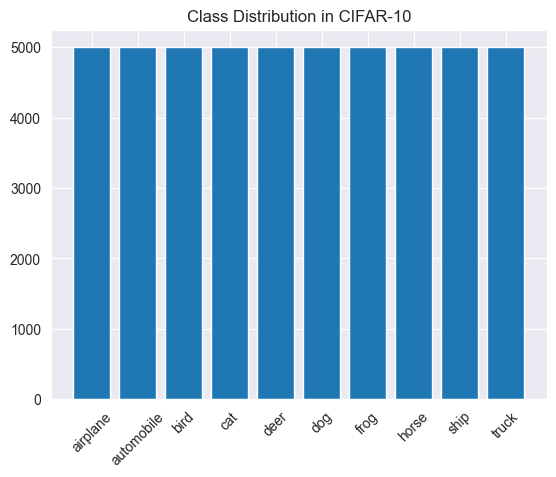

In [9]:
def get_class_distribution(dataset: data.Dataset) -> dict:
    """
    Compute the class distribution of a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to analyze.
        
    Returns:
        dict: A dictionary where keys are class indices and values are counts.
    """
    class_counts = {}
    for _, label in dataset:
        label = int(label)
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts


# Get class distribution
class_distribution = get_class_distribution(dataset)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print class distribution
for class_index, count in class_distribution.items():
    print(f'Class {class_index}/{class_labels[class_index]}: {count}')

counts = [class_distribution[i] for i in range(len(class_labels))]

plt.bar(class_labels, counts)
plt.xticks(rotation=45)
plt.title('Class Distribution in CIFAR-10')
plt.show()

In [10]:
# dataset looks to be very balanced
sample, label = dataset[0][:2]
input_shape = dataset[0][0].size()
# Print the first sample and label
print(f'First Sample: {sample}')
print(f'Label Value: {label}')
print(f'Input Shape: {input_shape}')

First Sample: tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.

In [11]:
def get_value_range(dataset: data.Dataset) -> tuple:
    """
    Obtain the range of values in a dataset.
    
    Parameters:
        dataset (torch.utils.data.Dataset): The dataset to inspect.
        
    Returns:
        tuple: A tuple containing the minimum and maximum values.
    """
    min_value = float('inf')
    max_value = float('-inf')
    for sample, _ in dataset:
        min_value = min(min_value, torch.min(sample).item())
        max_value = max(max_value, torch.max(sample).item())
    return min_value, max_value


# Get and print the range of values for the training set
min_value, max_value = get_value_range(dataset)
print(f'Value Range: {min_value} to {max_value}')

Value Range: -1.0 to 1.0


### Applying benchmark classifier

In [12]:
# Capture all the hyperparameters in a dictionary
Hyperparams = {
    'learning_rate': 3e-3,
    'batch_size': 64,
    'num_epochs': 500,
    'optimizer': 'SGD',
    'momentum': 0.9,
    'patience': 7
}

In [13]:
# Define the 1-node hidden layer classifier
class Classifier(nn.Module):
    def __init__(self,
                 input_size: int,
                 num_classes: int,
                 hidden_layers: list,
                 init_method: str = 'lecun_uniform',
                 activation_function: nn.Module = nn.LeakyReLU(),
                 dropout: float = None,
                 normalization: str = None):
        """
        Initialize the layers of the classifier.
        
        Parameters:
            input_size (int): The number of features in the input data.
            num_classes (int): The number of classes in the dataset.
            hidden_layers (list): List of integers representing the number of units in each hidden layer.
            init_method (str): The weight initialization method ('lecun_uniform', 'lecun_normal', 
                               'xavier_uniform', 'xavier_normal', 'kaiming_uniform', or 'kaiming_normal').
            activation_function (nn.Module): Activation function instance to use. Default is LeakyReLU.
            dropout (float): Dropout rate (0 to 1), if dropout is to be applied. None for no dropout.
            normalization (str): Type of normalization ('batch', 'layer', or None).
        """
        super(Classifier, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        layers = []
        in_features = input_size  # Input size to the first hidden layer

        # Function to initialize weights
        def init_weights(m):
            if type(m) == nn.Linear:
                if init_method == 'lecun_uniform':
                    pass  # LeCun uniform initialization is the default for nn.Linear
                else:
                    if isinstance(activation_function, nn.LeakyReLU):
                        nonlinearity = 'leaky_relu'
                        a = activation_function.negative_slope  # Get the negative slope from LeakyReLU
                    elif isinstance(activation_function, nn.PReLU):
                        nonlinearity = 'leaky_relu'  # PReLU is also a type of leaky ReLU
                        a = activation_function.weight.item()  # Get the negative slope from PReLU
                    else:
                        raise ValueError(f'Unsupported activation function: {activation_function}')

                    if init_method.endswith('uniform'):
                        gain = nn.init.calculate_gain(nonlinearity, a)
                        nn.init.xavier_uniform_(m.weight, gain=gain) if 'xavier' in init_method else \
                            nn.init.kaiming_uniform_(m.weight, a=a, mode='fan_in',
                                                     nonlinearity=nonlinearity) if 'kaiming' in init_method else None
                    else:  # normal initialization
                        std = nn.init.calculate_gain(nonlinearity, a)
                        nn.init.xavier_normal_(m.weight, std=std) if 'xavier' in init_method else \
                            nn.init.kaiming_normal_(m.weight, a=a, mode='fan_in',
                                                    nonlinearity=nonlinearity) if 'kaiming' in init_method else \
                                nn.init.normal_(m.weight, std=1.0)  # lecun_normal

        # Create hidden layers
        for out_features in hidden_layers:
            linear_layer = nn.Linear(in_features, out_features)
            linear_layer.apply(init_weights)
            layers.append(linear_layer)
            if normalization == 'batch':
                layers.append(nn.BatchNorm1d(out_features))
            elif normalization == 'layer':
                layers.append(nn.LayerNorm(out_features))
            layers.append(activation_function)
            if dropout:
                layers.append(nn.Dropout(dropout))
            in_features = out_features  # Update in_features for the next layer

        # Output layer
        output_layer = nn.Linear(in_features, num_classes)
        output_layer.apply(init_weights)
        layers.append(output_layer)

        self.layers = nn.Sequential(*layers)  # Create a sequential container from the layers list

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass through the network.
        
        Parameters:
            x (torch.Tensor): The input data.
            
        Returns:
            torch.Tensor: The output of the network.
        """
        x = x.view(-1, self.input_size)
        x = self.layers(x)  # Apply the layers to the input data
        return x

    def save_model(self, path: str):
        """
        Save the trained parameters of the network to a file.
        
        Parameters:
            path (str): The file path to save the trained parameters.
        """
        torch.save(self.state_dict(), path)
        print(f'Model parameters saved to {path}')

    @classmethod
    def load_model(cls, path: str, input_size: int, num_classes: int, hidden_layers: list):
        """
        Load the trained parameters into a new network.
        
        Parameters:
            path (str): The file path to load the trained parameters from.
            input_size (int): The number of features in the input data.
            num_classes (int): The number of classes in the dataset.
            hidden_layers (list): List of integers representing the number of units in each hidden layer.
            
        Returns:
            OneNodeClassifier: A new network with the loaded trained parameters.
        """
        model = cls(input_size, num_classes, hidden_layers)
        model.load_state_dict(torch.load(path))
        print(f'Model parameters loaded from {path}')
        return model

    def plot_model(self):
        """
        Display the summary and plot the network.
        """
        # input_size is already the product of C*H*W
        input_size = (self.input_size,)

        original_device = next(self.parameters()).device  # Store the original device
        self.to('cpu')  # Temporarily move model to CPU

        summary(self, input_size=input_size, device='cpu')  # Print summary

        # x = torch.randn(1, *input_size, device='cpu')  # Create a random input tensor on the CPU
        # y = self(x)
        # dot = make_dot(y, params=dict(self.named_parameters()))  # Create computation graph
        # dot.render(format='png', filename='network_graph')  # Save computation graph to file
        # plt.imshow(plt.imread('network_graph.png'))  # Display computation graph
        # plt.axis('off')
        # plt.show()

        self.to(original_device)  # Move model back to its original device

    def predict(self, x: torch.Tensor, show_images: bool = False) -> torch.Tensor:
        """
        Predict the class probabilities and optionally show images with predictions.
        
        Parameters:
            x (torch.Tensor): The input data.
            show_images (bool): Whether to display images with predictions.
            
        Returns:
            torch.Tensor: The class probabilities.
        """
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        x = x.to(device)

        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            if show_images:
                for i, image in enumerate(x.cpu()):  # Move images back to CPU for displaying
                    plt.imshow(image.permute(1, 2, 0))  # Assume image tensor shape is (C, H, W)
                    plt.title(f'Predicted: {class_names[predictions[i]]} ({probabilities[i][predictions[i]]:.2f})')
                    plt.show()

        return probabilities

In [14]:
# Get the input size and number of classes from the dataset
input_size = np.prod(dataset[0][0].shape)
num_classes = len(dataset.classes)
# Create DataLoaders for the training and testing sets
train_loader = data.DataLoader(training_set, batch_size=Hyperparams['batch_size'], shuffle=True)
subtrain_loader = data.DataLoader(subtrain_set, batch_size=Hyperparams['batch_size'], shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=Hyperparams['batch_size'], shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=Hyperparams['batch_size'], shuffle=False)

In [15]:
# dispaly the first 10 examples of subtraining with labels
images, labels = next(iter(subtrain_loader))
print(f'Labels: {labels}')
print(f'Images: {images}')

Labels: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0,

In [16]:
# print shape of input samples and labels
print(f'Input Shape: {images.shape}')
print(f'Label Shape: {labels.shape}')

Input Shape: torch.Size([64, 3, 32, 32])
Label Shape: torch.Size([64, 10])


In [17]:
# Instantiate the model with the input size and number of classes
oneNodeModel = Classifier(input_size, num_classes, [1])
# plot the model
oneNodeModel.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]           3,073
         LeakyReLU-2                    [-1, 1]               0
            Linear-3                   [-1, 10]              20
Total params: 3,093
Trainable params: 3,093
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [18]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(oneNodeModel.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

In [19]:
class EarlyStopping:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""

    def __init__(self, patience: int = 5):
        self.patience = patience
        self.counter = 0
        self.best_acc = None  # Changed from best_loss to best_acc
        self.early_stop = False

    def __call__(self, val_acc: float):  # Changed parameter name from val_loss to val_acc
        if self.best_acc is None:
            self.best_acc = val_acc  # Changed from best_loss to best_acc
        elif val_acc < self.best_acc:  # Changed comparison from > to <
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_acc = val_acc  # Changed from best_loss to best_acc
            self.counter = 0

In [20]:
def train_epoch(model: nn.Module, data_loader: data.DataLoader, criterion: nn.Module, optimizer: optim.Optimizer) -> (
        float, float):
    """Train the model for one epoch."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(data_loader), correct / total


def validate_model(model: nn.Module, data_loader: data.DataLoader, criterion: nn.Module) -> (float, float):
    """Validate the model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(data_loader), correct / total


def train_and_evaluate(model: nn.Module,
                       subtrain_loader: data.DataLoader,
                       val_loader: data.DataLoader,
                       train_loader: data.DataLoader,
                       criterion: nn.Module,
                       optimizer: optim.Optimizer,
                       hyperparams: dict) -> (int, float):
    """
    Train and evaluate the model to find the best epoch number on subtraining data, 
    then retrain on the entire training set with the best epoch number.

    Parameters:
        model (nn.Module): The model to be trained and evaluated.
        subtrain_loader (torch.utils.data.DataLoader): DataLoader for the subtraining data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        train_loader (torch.utils.data.DataLoader): DataLoader for the entire training data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        hyperparams (dict): Dictionary of hyperparameters including 'num_epochs'.

    Returns:
        int: The best epoch number.
        float: The training runtime for the second phase.
    """

    # First phase: training on subtraining data and validating to find the best epoch number
    early_stopping = EarlyStopping(patience=Hyperparams['patience'])
    best_epoch = 0
    best_val_acc = 0.0

    # Lists to store loss and accuracy values
    subtrain_losses, subtrain_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []

    for epoch in range(hyperparams['num_epochs']):  # assuming a max of hyperparams['num_epochs'] for simplicity
        train_loss, train_acc = train_epoch(model, subtrain_loader, criterion, optimizer)
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        subtrain_losses.append(train_loss)
        subtrain_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(
            f'Epoch {epoch}/{hyperparams["num_epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        early_stopping(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Second phase: retraining on the entire training set with the best epoch number
    start_time = time.time()

    for epoch in range(best_epoch + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f'Epoch {epoch}/{best_epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    training_runtime = time.time() - start_time

    # Plotting
    epochs_subtrain = list(range(1, len(subtrain_losses) + 1))
    epochs_train = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(10, 4))

    # Subtraining and Validation Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_subtrain, subtrain_losses, label='Subtrain Loss')
    plt.plot(epochs_subtrain, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Subtraining and Validation Losses')

    # Subtraining and Validation Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_subtrain, subtrain_accuracies, label='Subtrain Accuracy')
    plt.plot(epochs_subtrain, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Subtraining and Validation Accuracies')

    plt.show()  # Show the plots for the first phase

    plt.figure(figsize=(10, 4))

    # Training Loss and Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_train, train_losses, label='Training Loss')
    plt.legend()
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_train, train_accuracies, label='Training Accuracy')
    plt.legend()
    plt.title('Training Accuracy')

    plt.show()  # Show the plots for the second phase

    print(f'Best Epoch: {best_epoch}')
    print(f'Training Runtime: {training_runtime:.2f} seconds')

    return best_epoch, training_runtime


In [21]:
def get_predictions(model: nn.Module, data_loader: data.DataLoader) -> (torch.Tensor, torch.Tensor):
    """Get model predictions and true labels.
    
    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): The DataLoader for the test set.

    Returns:
        tuple: A tuple containing the true labels and the predicted labels.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = torch.argmax(labels, dim=1)  # Convert one-hot to class indices if necessary
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            all_labels.append(labels)
            all_preds.append(preds)
    return torch.cat(all_labels), torch.cat(all_preds)

In [22]:
def evaluate_and_plot(model: nn.Module, data_loader: data.DataLoader) -> None:
    """
    Evaluate the model on the given data loader, print a classification report,
    and plot a confusion matrix.

    Parameters:
        model (torch.nn.Module): The trained model.
        data_loader (torch.utils.data.DataLoader): The data loader containing the testing data.

    Returns:
        None
    """
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # Get true labels and predicted labels
    true_labels, predicted_labels = get_predictions(model, data_loader)

    # Convert to numpy arrays for use with sklearn
    true_labels_np = true_labels.cpu().numpy()
    predicted_labels_np = predicted_labels.cpu().numpy()

    # Generate classification report
    report = classification_report(true_labels_np, predicted_labels_np, target_names=class_names, zero_division=0)
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels_np, predicted_labels_np)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [23]:
def experiment_and_evaluate(model: nn.Module,
                            subtrain_loader: data.DataLoader,
                            val_loader: data.DataLoader,
                            criterion: nn.Module,
                            optimizer: optim.Optimizer,
                            hyperparams: dict) -> int:
    """
    Train on a third of the subtraining set and evaluate on the validation set 
    to run experiments on

    Parameters:
        model (nn.Module): The model to be trained and evaluated.
        subtrain_loader (torch.utils.data.DataLoader): DataLoader for the subtraining data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        hyperparams (dict): Dictionary of hyperparameters including 'num_epochs'.

    Returns:
        int: The best epoch number.
    """

    # Determine the number of batches to use for subtraining
    third_length = len(subtrain_loader.dataset) // 3
    truncated_dataset = data.Subset(subtrain_loader.dataset, indices=range(third_length))
    truncated_subtrain_loader = data.DataLoader(
        truncated_dataset,
        batch_size=subtrain_loader.batch_size,
        shuffle=True,
        num_workers=subtrain_loader.num_workers
    )

    early_stopping = EarlyStopping(patience=hyperparams['patience'])
    best_epoch = 0
    best_val_acc = 0.0

    # Lists to store loss and accuracy values
    subtrain_losses, subtrain_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(hyperparams['num_epochs']):
        train_loss, train_acc = train_epoch(model, truncated_subtrain_loader, criterion, optimizer)
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        subtrain_losses.append(train_loss)
        subtrain_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(
            f'Epoch {epoch}/{hyperparams["num_epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        early_stopping(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Plotting
    epochs_subtrain = list(range(1, len(subtrain_losses) + 1))

    plt.figure(figsize=(10, 4))

    # Subtraining and Validation Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_subtrain, subtrain_losses, label='Subtrain Loss')
    plt.plot(epochs_subtrain, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Subtrain and Validation Losses')

    # Subtraining and Validation Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs_subtrain, subtrain_accuracies, label='Subtrain Accuracy')
    plt.plot(epochs_subtrain, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Subtrain and Validation Accuracies')

    plt.show()  # Show the plots

    evaluate_and_plot(model, val_loader)

    print(f'Best Epoch: {best_epoch}')

    return best_epoch


Epoch 0/500, Train Loss: 2.3148, Train Acc: 0.1398, Val Loss: 2.2640, Val Acc: 0.1583
Epoch 1/500, Train Loss: 2.2144, Train Acc: 0.1828, Val Loss: 2.2111, Val Acc: 0.1754
Epoch 2/500, Train Loss: 2.1693, Train Acc: 0.1866, Val Loss: 2.1765, Val Acc: 0.1719
Epoch 3/500, Train Loss: 2.1403, Train Acc: 0.1883, Val Loss: 2.1527, Val Acc: 0.1779
Epoch 4/500, Train Loss: 2.1153, Train Acc: 0.1935, Val Loss: 2.1327, Val Acc: 0.1805
Epoch 5/500, Train Loss: 2.1001, Train Acc: 0.1937, Val Loss: 2.1212, Val Acc: 0.1790
Epoch 6/500, Train Loss: 2.0850, Train Acc: 0.1920, Val Loss: 2.1134, Val Acc: 0.1792
Epoch 7/500, Train Loss: 2.0739, Train Acc: 0.1932, Val Loss: 2.1046, Val Acc: 0.1779
Epoch 8/500, Train Loss: 2.0655, Train Acc: 0.1913, Val Loss: 2.0941, Val Acc: 0.1765
Epoch 9/500, Train Loss: 2.0568, Train Acc: 0.1894, Val Loss: 2.0931, Val Acc: 0.1772
Epoch 10/500, Train Loss: 2.0532, Train Acc: 0.1917, Val Loss: 2.0905, Val Acc: 0.1762
Epoch 11/500, Train Loss: 2.0463, Train Acc: 0.1954, 

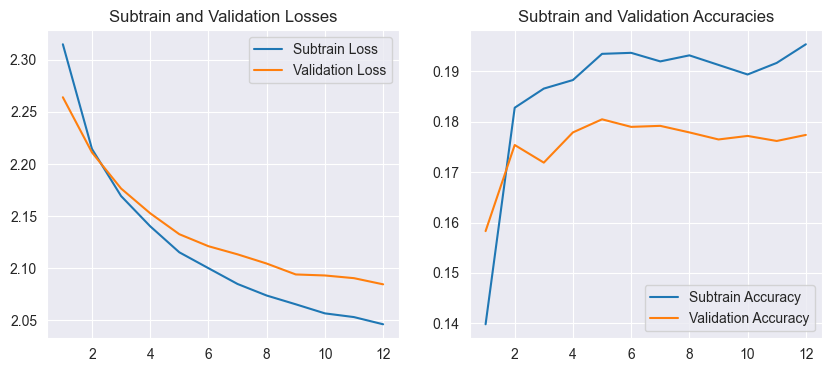

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1007
  automobile       0.15      0.32      0.21      1011
        bird       0.09      0.05      0.07       990
         cat       0.00      0.00      0.00      1002
        deer       0.11      0.07      0.09      1028
         dog       0.00      0.00      0.00       962
        frog       0.17      0.82      0.28       980
       horse       0.00      0.00      0.00      1065
        ship       0.27      0.55      0.36       946
       truck       0.00      0.00      0.00      1009

    accuracy                           0.18     10000
   macro avg       0.08      0.18      0.10     10000
weighted avg       0.08      0.18      0.10     10000


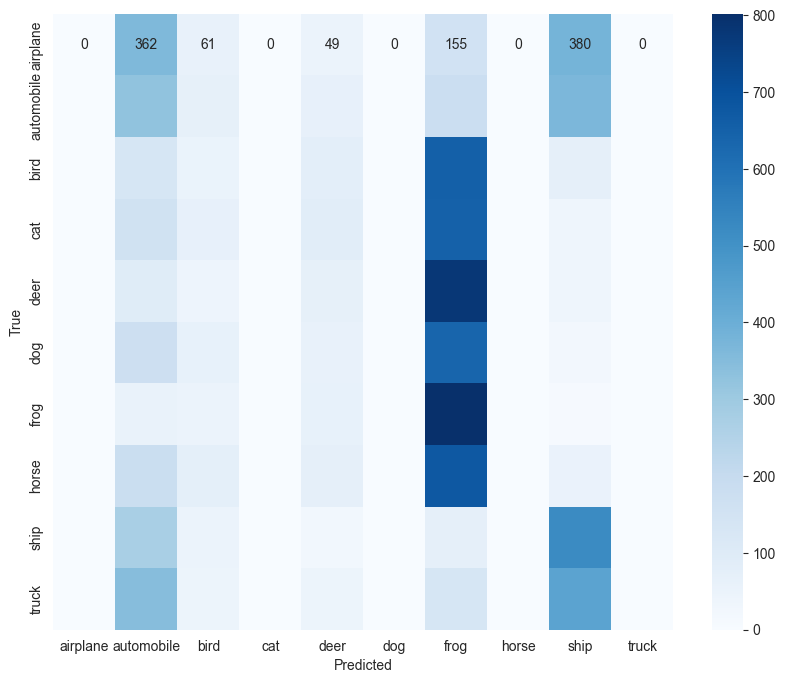

Best Epoch: 4


In [24]:
# experiment and evaluate first phase
best_epoch = experiment_and_evaluate(
    model=oneNodeModel,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

Epoch 0/500, Train Loss: 2.0611, Train Acc: 0.1880, Val Loss: 2.0800, Val Acc: 0.1758
Epoch 1/500, Train Loss: 2.0516, Train Acc: 0.1873, Val Loss: 2.0658, Val Acc: 0.1770
Epoch 2/500, Train Loss: 2.0445, Train Acc: 0.1861, Val Loss: 2.0731, Val Acc: 0.1802
Epoch 3/500, Train Loss: 2.0414, Train Acc: 0.1875, Val Loss: 2.0647, Val Acc: 0.1712
Epoch 4/500, Train Loss: 2.0381, Train Acc: 0.1879, Val Loss: 2.0641, Val Acc: 0.1735
Epoch 5/500, Train Loss: 2.0349, Train Acc: 0.1882, Val Loss: 2.0605, Val Acc: 0.1825
Epoch 6/500, Train Loss: 2.0338, Train Acc: 0.1869, Val Loss: 2.0570, Val Acc: 0.1817
Epoch 7/500, Train Loss: 2.0317, Train Acc: 0.1881, Val Loss: 2.0566, Val Acc: 0.1729
Epoch 8/500, Train Loss: 2.0303, Train Acc: 0.1867, Val Loss: 2.0584, Val Acc: 0.1769
Epoch 9/500, Train Loss: 2.0296, Train Acc: 0.1884, Val Loss: 2.0574, Val Acc: 0.1748
Epoch 10/500, Train Loss: 2.0285, Train Acc: 0.1919, Val Loss: 2.0507, Val Acc: 0.1826
Epoch 11/500, Train Loss: 2.0267, Train Acc: 0.1878, 

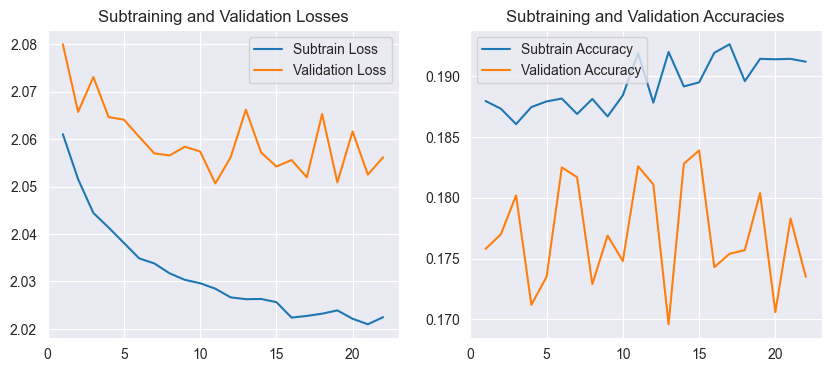

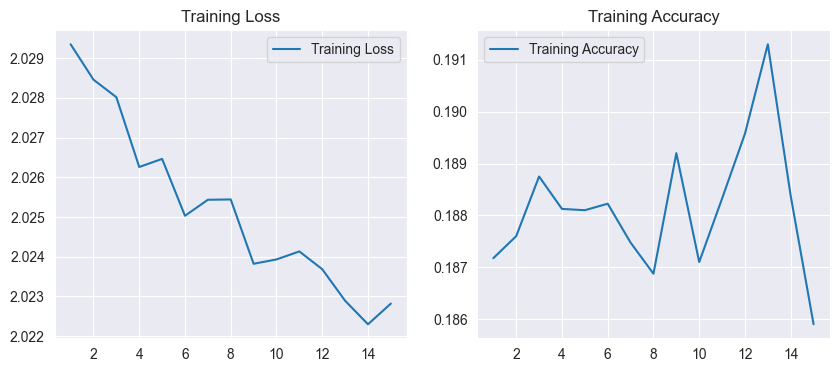

Best Epoch: 14
Training Runtime: 94.39 seconds


In [25]:
# final benchmark training
best_epoch, training_runtime = train_and_evaluate(
    model=oneNodeModel,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

              precision    recall  f1-score   support

    airplane       0.15      0.05      0.07       999
  automobile       0.18      0.57      0.27       988
        bird       0.12      0.24      0.16      1002
         cat       0.00      0.00      0.00      1059
        deer       0.13      0.09      0.11       931
         dog       0.00      0.00      0.00      1032
        frog       0.21      0.67      0.32      1049
       horse       0.00      0.00      0.00       960
        ship       0.28      0.17      0.22       986
       truck       0.00      0.00      0.00       994

    accuracy                           0.18     10000
   macro avg       0.11      0.18      0.12     10000
weighted avg       0.11      0.18      0.12     10000


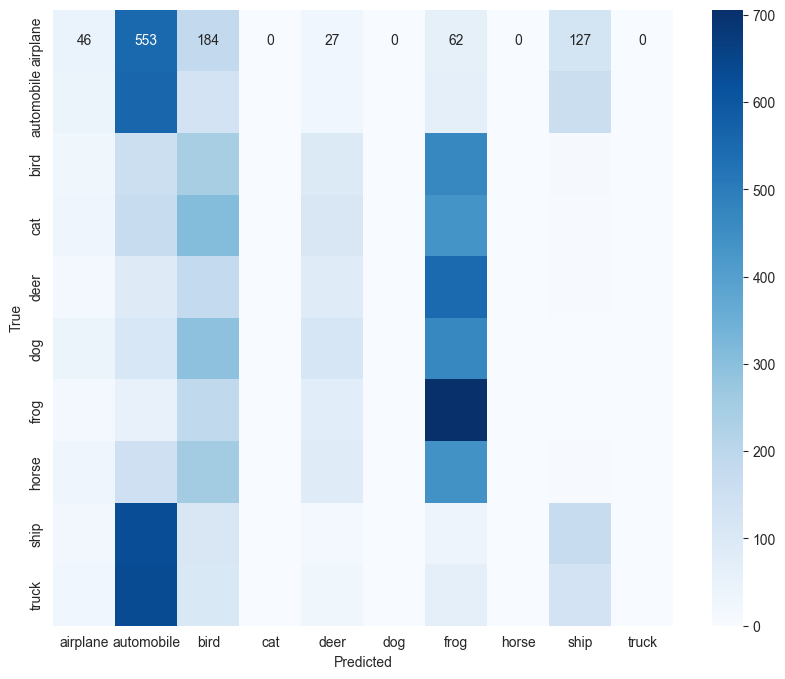

In [26]:
evaluate_and_plot(oneNodeModel, test_loader)

The one node classifier is not very good with only 18% test accuracy

### Run some experiments on the CIFAR-10 dataset
0. Architectures (more hidden units)
1. Weight Initialization (Kaiming Normal)
2. Activation functions (PReLU)
3. Loss functions (focal loss)
4. Normalization/Standardization (batch normalization, layer normalization)
5. Regularization (a) weight decay/l2-regularization, (b) dropout, (c) data augmentations)
6. Ensembling (ensemble of top 3)
(Optional) Architectures (mlp-mixer)


### Experiment 0: we are going to add few more hidden units and test to see if the model performs better

In [27]:
# more hidden units [2048, 1024, 512, 128] so the features reduce
# Instantiate the model with the input size and number of classes
model1 = Classifier(input_size, num_classes, [2048, 1024, 512, 128])
# plot the model
model1.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LeakyReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
         LeakyReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 8,983,434
Trainable params: 8,983,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 34.27
Estimated Total Size (MB): 34.34
-------------------------------------

In [28]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model1.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 2.2962, Train Acc: 0.1547, Val Loss: 2.2867, Val Acc: 0.1573
Epoch 1/500, Train Loss: 2.2536, Train Acc: 0.1974, Val Loss: 2.1995, Val Acc: 0.2075
Epoch 2/500, Train Loss: 2.0956, Train Acc: 0.2364, Val Loss: 2.0199, Val Acc: 0.2674
Epoch 3/500, Train Loss: 1.9503, Train Acc: 0.2855, Val Loss: 1.9179, Val Acc: 0.3003
Epoch 4/500, Train Loss: 1.8463, Train Acc: 0.3270, Val Loss: 1.8317, Val Acc: 0.3459
Epoch 5/500, Train Loss: 1.7451, Train Acc: 0.3728, Val Loss: 1.7426, Val Acc: 0.3718
Epoch 6/500, Train Loss: 1.6554, Train Acc: 0.4018, Val Loss: 1.7194, Val Acc: 0.3821
Epoch 7/500, Train Loss: 1.5735, Train Acc: 0.4268, Val Loss: 1.6704, Val Acc: 0.4034
Epoch 8/500, Train Loss: 1.5065, Train Acc: 0.4531, Val Loss: 1.6340, Val Acc: 0.4141
Epoch 9/500, Train Loss: 1.4304, Train Acc: 0.4822, Val Loss: 1.6325, Val Acc: 0.4259
Epoch 10/500, Train Loss: 1.3615, Train Acc: 0.5046, Val Loss: 1.6375, Val Acc: 0.4296
Epoch 11/500, Train Loss: 1.2947, Train Acc: 0.5329, 

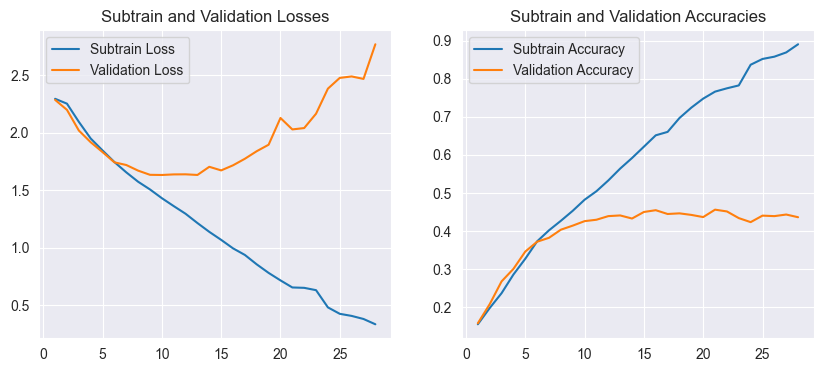

              precision    recall  f1-score   support

    airplane       0.49      0.36      0.42      1007
  automobile       0.45      0.67      0.54      1011
        bird       0.32      0.36      0.34       990
         cat       0.29      0.32      0.30      1002
        deer       0.33      0.41      0.36      1028
         dog       0.44      0.22      0.29       962
        frog       0.48      0.54      0.51       980
       horse       0.53      0.50      0.51      1065
        ship       0.62      0.52      0.56       946
       truck       0.51      0.46      0.48      1009

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.43     10000
weighted avg       0.45      0.44      0.43     10000


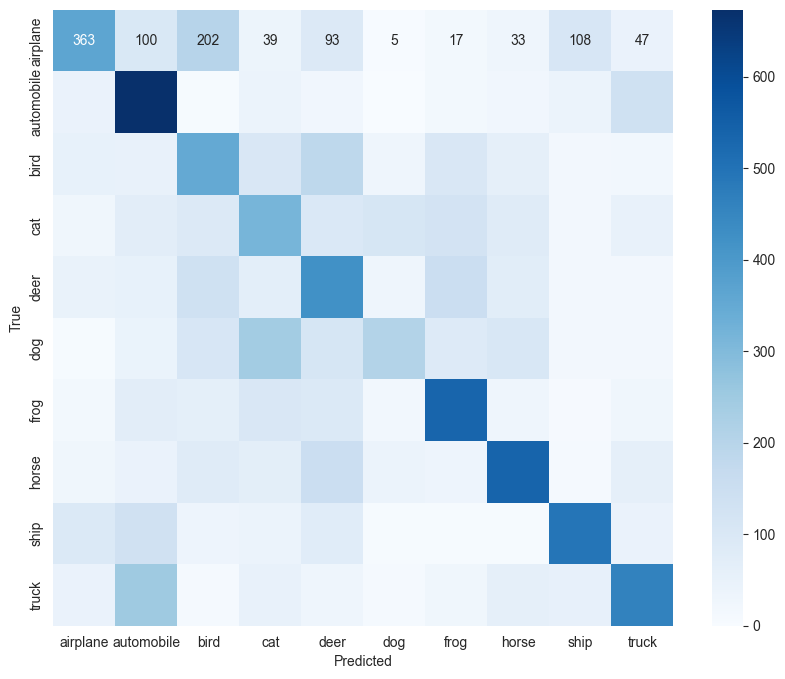

Best Epoch: 20


In [29]:
best_epoch = experiment_and_evaluate(
    model=model1,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

More layers and our network performs indeed better with 44% accuracy on validation set

### Experiment 1: We are going to try a different initialization method and see if the model performs better
Currently, our model is initialized with LeCun Uniform as it is the default initialization method with Linear layers in PyTorch.
However, it was mostly designed to work with sigmoidal activation functions. However, the Kaiming initialization is designed to work well with ReLU activation functions.
Therefore applying the Kaiming initialization to the model will potentially give better results.

In [30]:
model2 = Classifier(
    input_size,
    num_classes,
    [2048, 1024, 512, 128],
    init_method='kaiming_normal')
# plot the model
model2.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LeakyReLU-2                 [-1, 2048]               0
            Linear-3                 [-1, 1024]       2,098,176
         LeakyReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 8,983,434
Trainable params: 8,983,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 34.27
Estimated Total Size (MB): 34.34
-------------------------------------

In [31]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model2.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8709, Train Acc: 0.3352, Val Loss: 1.7386, Val Acc: 0.3896
Epoch 1/500, Train Loss: 1.5134, Train Acc: 0.4710, Val Loss: 1.6267, Val Acc: 0.4226
Epoch 2/500, Train Loss: 1.2991, Train Acc: 0.5543, Val Loss: 1.6048, Val Acc: 0.4425
Epoch 3/500, Train Loss: 1.1096, Train Acc: 0.6259, Val Loss: 1.6375, Val Acc: 0.4411
Epoch 4/500, Train Loss: 0.9019, Train Acc: 0.7062, Val Loss: 1.7492, Val Acc: 0.4237
Epoch 5/500, Train Loss: 0.7258, Train Acc: 0.7695, Val Loss: 1.7964, Val Acc: 0.4414
Epoch 6/500, Train Loss: 0.5628, Train Acc: 0.8235, Val Loss: 1.8356, Val Acc: 0.4373
Epoch 7/500, Train Loss: 0.4465, Train Acc: 0.8689, Val Loss: 1.9577, Val Acc: 0.4429
Epoch 8/500, Train Loss: 0.3195, Train Acc: 0.9091, Val Loss: 2.0749, Val Acc: 0.4405
Epoch 9/500, Train Loss: 0.2458, Train Acc: 0.9354, Val Loss: 2.1679, Val Acc: 0.4374
Epoch 10/500, Train Loss: 0.1990, Train Acc: 0.9499, Val Loss: 2.2692, Val Acc: 0.4377
Epoch 11/500, Train Loss: 0.1541, Train Acc: 0.9624, 

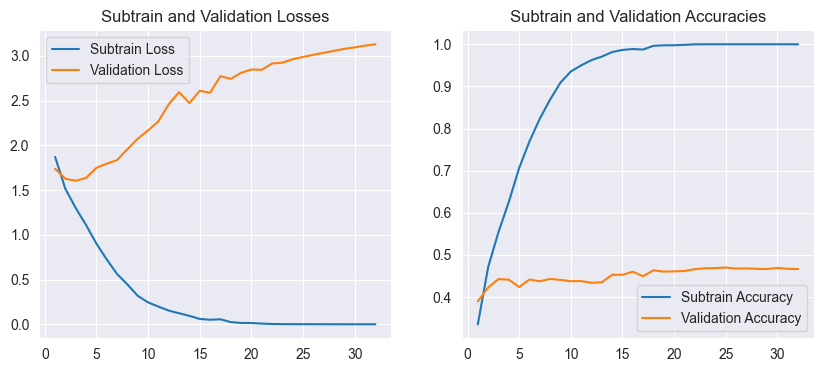

              precision    recall  f1-score   support

    airplane       0.52      0.56      0.54      1007
  automobile       0.56      0.58      0.57      1011
        bird       0.38      0.38      0.38       990
         cat       0.30      0.30      0.30      1002
        deer       0.40      0.40      0.40      1028
         dog       0.36      0.35      0.35       962
        frog       0.51      0.48      0.49       980
       horse       0.54      0.52      0.53      1065
        ship       0.59      0.61      0.60       946
       truck       0.51      0.48      0.50      1009

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000


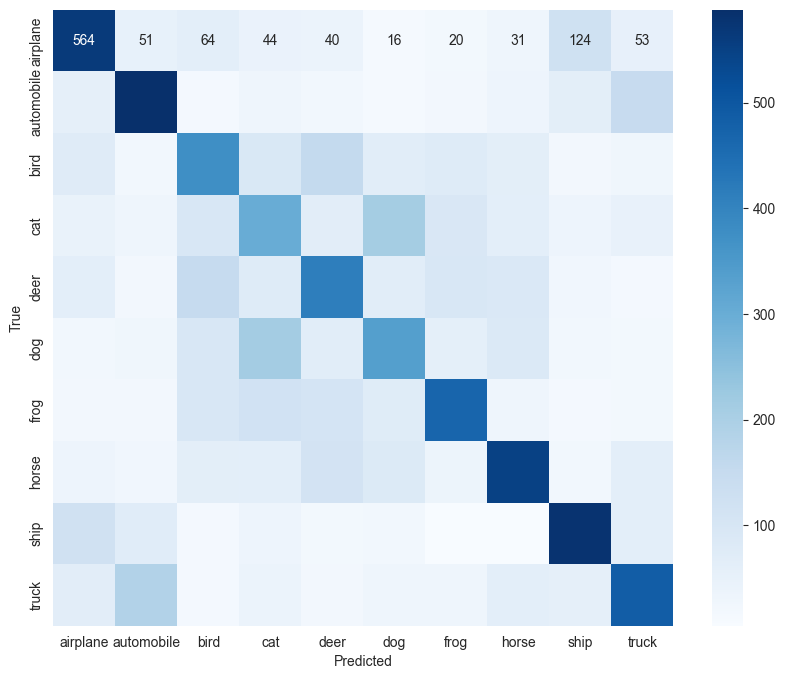

Best Epoch: 24


In [32]:
best_epoch = experiment_and_evaluate(
    model=model2,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

Ok model 2 with kaiming initialization performs even better with 47% accuracy on the validation set

### Experiment 2: We are going to try the PRELU activation
 We are using PRELU here where the activation coefficient $a$ is learned, unlike LeakyReLU.

In [33]:
model3 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU())
# plot the model
model3.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
             PReLU-2                 [-1, 2048]               1
            Linear-3                 [-1, 1024]       2,098,176
             PReLU-4                 [-1, 1024]               1
            Linear-5                  [-1, 512]         524,800
             PReLU-6                  [-1, 512]               1
            Linear-7                  [-1, 128]          65,664
             PReLU-8                  [-1, 128]               1
            Linear-9                   [-1, 10]           1,290
Total params: 8,983,438
Trainable params: 8,983,438
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 34.27
Estimated Total Size (MB): 34.34
-------------------------------------

In [34]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model3.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8406, Train Acc: 0.3464, Val Loss: 1.7129, Val Acc: 0.3941
Epoch 1/500, Train Loss: 1.5129, Train Acc: 0.4775, Val Loss: 1.6226, Val Acc: 0.4288
Epoch 2/500, Train Loss: 1.3172, Train Acc: 0.5504, Val Loss: 1.6246, Val Acc: 0.4348
Epoch 3/500, Train Loss: 1.1629, Train Acc: 0.6098, Val Loss: 1.6034, Val Acc: 0.4434
Epoch 4/500, Train Loss: 0.9674, Train Acc: 0.6851, Val Loss: 1.6442, Val Acc: 0.4436
Epoch 5/500, Train Loss: 0.7970, Train Acc: 0.7451, Val Loss: 1.6660, Val Acc: 0.4484
Epoch 6/500, Train Loss: 0.6176, Train Acc: 0.8101, Val Loss: 1.8055, Val Acc: 0.4447
Epoch 7/500, Train Loss: 0.4687, Train Acc: 0.8621, Val Loss: 1.9315, Val Acc: 0.4411
Epoch 8/500, Train Loss: 0.3470, Train Acc: 0.9032, Val Loss: 1.9729, Val Acc: 0.4353
Epoch 9/500, Train Loss: 0.2516, Train Acc: 0.9332, Val Loss: 2.1645, Val Acc: 0.4453
Epoch 10/500, Train Loss: 0.2120, Train Acc: 0.9442, Val Loss: 2.2229, Val Acc: 0.4503
Epoch 11/500, Train Loss: 0.1242, Train Acc: 0.9713, 

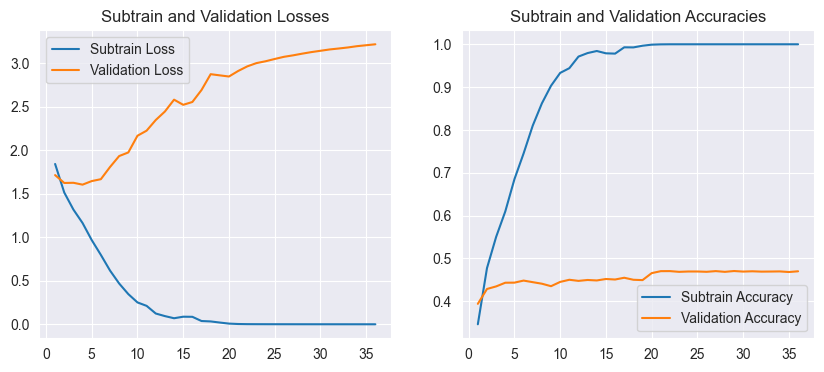

              precision    recall  f1-score   support

    airplane       0.53      0.54      0.54      1007
  automobile       0.57      0.58      0.58      1011
        bird       0.39      0.37      0.38       990
         cat       0.31      0.30      0.31      1002
        deer       0.38      0.42      0.40      1028
         dog       0.37      0.33      0.35       962
        frog       0.50      0.50      0.50       980
       horse       0.55      0.52      0.53      1065
        ship       0.57      0.64      0.60       946
       truck       0.51      0.50      0.51      1009

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000


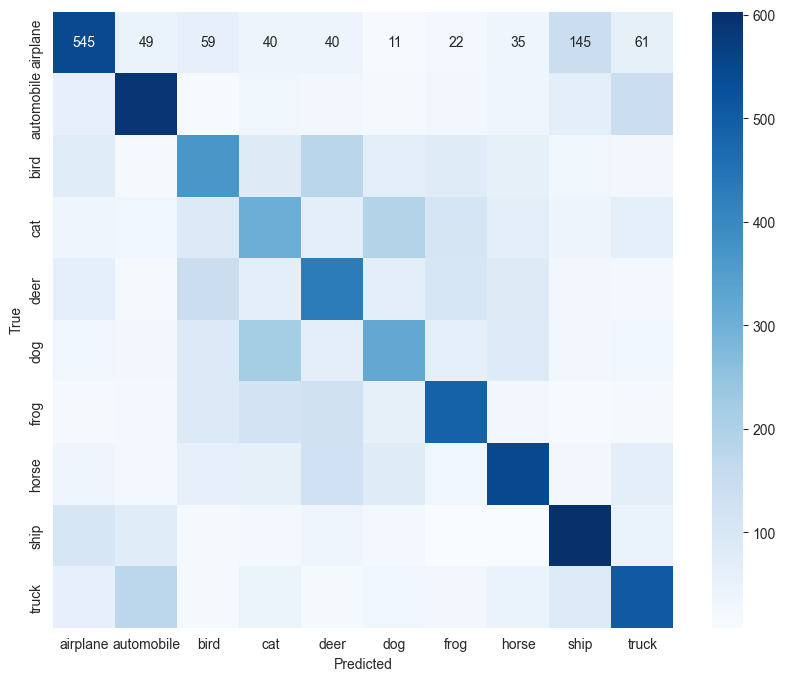

Best Epoch: 28


In [35]:
best_epoch = experiment_and_evaluate(
    model=model3,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

PReLU activation reaches 47% on the validation set as well so it's not conclusively better than LeakyReLU in this case. However, 
not having to find the best hyperparameter for LeakyReLU is a good way to get the best performance.

### Experiment 3: We are going to try the focal loss function which is known to be an error aware loss
 We are using the focal loss here because it is known to be an error aware loss which can help the model focus more on the samples it is having a hard time with.

In [36]:
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 1., gamma: float = 2., reduction: str = 'mean'):
        """
        Initializes the Focal Loss module.
        
        Parameters:
            alpha (float): Weighting factor for the rare class. Default is 1.
            gamma (float): Focusing parameter to down-weight the easy examples. Default is 2.
            reduction (str): Specifies the reduction to apply to the output: 
                             'none' | 'mean' | 'sum'. 'none': no reduction will 
                             be applied, 'mean': the sum of the output will be 
                             divided by the number of elements in the output, 
                             'sum': the output will be summed. Default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Computes the focal loss.
        
        Parameters:
            inputs (torch.Tensor): The input logits.
            targets (torch.Tensor): The ground-truth labels.
            
        Returns:
            torch.Tensor: The computed focal loss.
        """
        # Get the log softmax of the inputs
        log_softmax = F.log_softmax(inputs, dim=1)

        # Select the log softmax value at each true label index
        selected_log_probs = log_softmax.gather(1, targets.unsqueeze(1))
        selected_log_probs = selected_log_probs.squeeze(1)

        # Calculate the focal loss
        loss = -self.alpha * (1 - torch.exp(selected_log_probs)) ** self.gamma * selected_log_probs

        # Apply reduction
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


In [43]:
model4 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU())
# plot the model
model4.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
             PReLU-2                 [-1, 2048]               1
            Linear-3                 [-1, 1024]       2,098,176
             PReLU-4                 [-1, 1024]               1
            Linear-5                  [-1, 512]         524,800
             PReLU-6                  [-1, 512]               1
            Linear-7                  [-1, 128]          65,664
             PReLU-8                  [-1, 128]               1
            Linear-9                   [-1, 10]           1,290
Total params: 8,983,438
Trainable params: 8,983,438
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 34.27
Estimated Total Size (MB): 34.34
-------------------------------------

In [44]:
# Define the loss function
criterion = FocalLoss(alpha=1, gamma=2)  # using the default params 
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model4.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.3536, Train Acc: 0.3492, Val Loss: 1.2109, Val Acc: 0.3958
Epoch 1/500, Train Loss: 1.0214, Train Acc: 0.4761, Val Loss: 1.1477, Val Acc: 0.4274
Epoch 2/500, Train Loss: 0.8388, Train Acc: 0.5578, Val Loss: 1.1462, Val Acc: 0.4249
Epoch 3/500, Train Loss: 0.6810, Train Acc: 0.6308, Val Loss: 1.1538, Val Acc: 0.4356
Epoch 4/500, Train Loss: 0.5386, Train Acc: 0.6999, Val Loss: 1.1524, Val Acc: 0.4325
Epoch 5/500, Train Loss: 0.3981, Train Acc: 0.7749, Val Loss: 1.2016, Val Acc: 0.4397
Epoch 6/500, Train Loss: 0.2827, Train Acc: 0.8446, Val Loss: 1.2213, Val Acc: 0.4409
Epoch 7/500, Train Loss: 0.1865, Train Acc: 0.8943, Val Loss: 1.2787, Val Acc: 0.4344
Epoch 8/500, Train Loss: 0.1096, Train Acc: 0.9418, Val Loss: 1.3125, Val Acc: 0.4528
Epoch 9/500, Train Loss: 0.0785, Train Acc: 0.9563, Val Loss: 1.4283, Val Acc: 0.4381
Epoch 10/500, Train Loss: 0.0465, Train Acc: 0.9774, Val Loss: 1.4350, Val Acc: 0.4461
Epoch 11/500, Train Loss: 0.0399, Train Acc: 0.9792, 

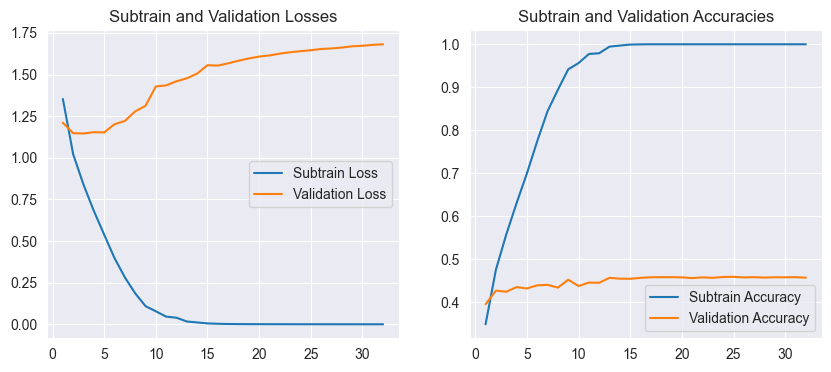

              precision    recall  f1-score   support

    airplane       0.51      0.52      0.52      1007
  automobile       0.56      0.53      0.55      1011
        bird       0.36      0.37      0.37       990
         cat       0.31      0.35      0.33      1002
        deer       0.38      0.39      0.38      1028
         dog       0.35      0.33      0.34       962
        frog       0.52      0.47      0.49       980
       horse       0.54      0.47      0.50      1065
        ship       0.57      0.62      0.60       946
       truck       0.51      0.51      0.51      1009

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000


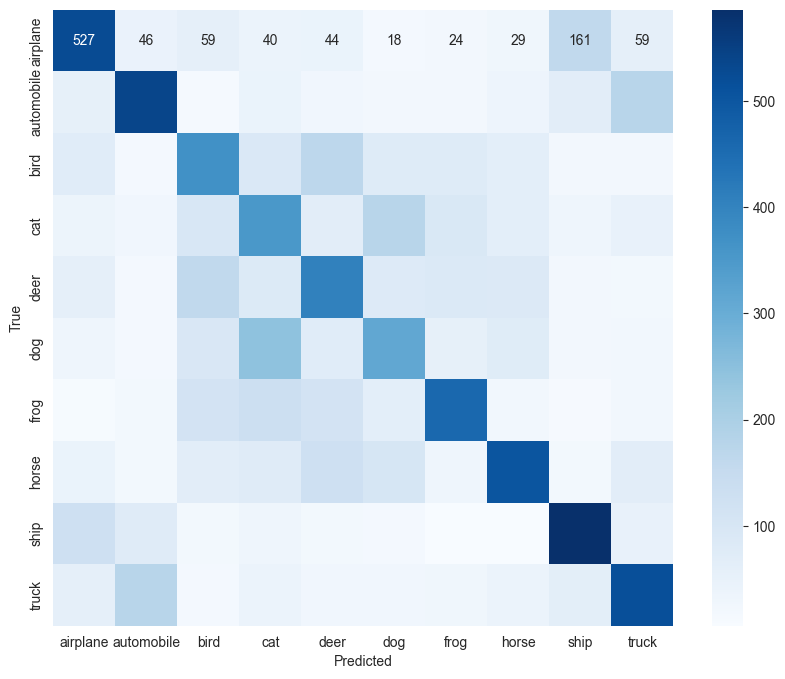

Best Epoch: 24


In [45]:
best_epoch = experiment_and_evaluate(
    model=model4,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

In this case, focal loss is not doing better than Cross-Entropy loss. This might be because the classes are very balanced in this dataset.
Therefore, we will continue to use the Cross-Entropy loss.

### Experiment 4: Compare Batch Normalization and Layer Normalization performance
 We are going to compare the performance of Batch Normalization and Layer Normalization. 

In [46]:
# Batch Normalization
model5 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='batch')
# plot the model
model5.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
             PReLU-3                 [-1, 2048]               1
            Linear-4                 [-1, 1024]       2,098,176
       BatchNorm1d-5                 [-1, 1024]           2,048
             PReLU-6                 [-1, 1024]               1
            Linear-7                  [-1, 512]         524,800
       BatchNorm1d-8                  [-1, 512]           1,024
             PReLU-9                  [-1, 512]               1
           Linear-10                  [-1, 128]          65,664
      BatchNorm1d-11                  [-1, 128]             256
            PReLU-12                  [-1, 128]               1
           Linear-13                   [-1, 10]           1,290
Total params: 8,990,862
Trainable param

In [47]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model5.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8107, Train Acc: 0.3696, Val Loss: 1.6463, Val Acc: 0.4253
Epoch 1/500, Train Loss: 1.3898, Train Acc: 0.5238, Val Loss: 1.5931, Val Acc: 0.4380
Epoch 2/500, Train Loss: 1.1327, Train Acc: 0.6268, Val Loss: 1.5994, Val Acc: 0.4423
Epoch 3/500, Train Loss: 0.8815, Train Acc: 0.7265, Val Loss: 1.6506, Val Acc: 0.4345
Epoch 4/500, Train Loss: 0.6570, Train Acc: 0.8117, Val Loss: 1.7190, Val Acc: 0.4285
Epoch 5/500, Train Loss: 0.4837, Train Acc: 0.8713, Val Loss: 1.7932, Val Acc: 0.4310
Epoch 6/500, Train Loss: 0.3603, Train Acc: 0.9109, Val Loss: 1.8350, Val Acc: 0.4402
Epoch 7/500, Train Loss: 0.2800, Train Acc: 0.9338, Val Loss: 1.8707, Val Acc: 0.4316
Epoch 8/500, Train Loss: 0.2237, Train Acc: 0.9482, Val Loss: 1.9604, Val Acc: 0.4428
Epoch 9/500, Train Loss: 0.1628, Train Acc: 0.9648, Val Loss: 2.0016, Val Acc: 0.4484
Epoch 10/500, Train Loss: 0.1123, Train Acc: 0.9790, Val Loss: 2.0283, Val Acc: 0.4525
Epoch 11/500, Train Loss: 0.0974, Train Acc: 0.9808, 

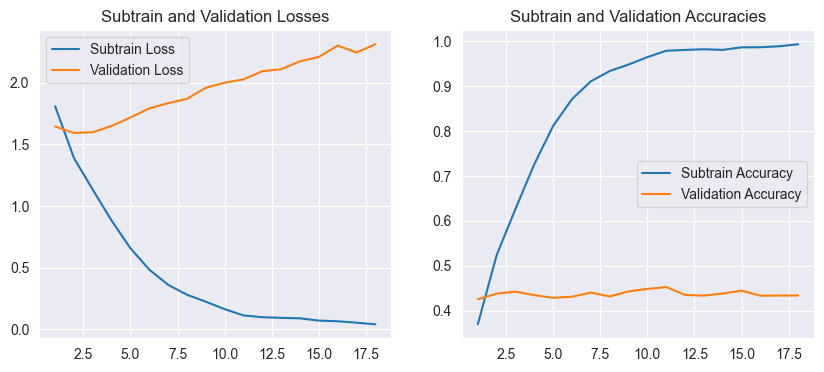

              precision    recall  f1-score   support

    airplane       0.50      0.54      0.52      1007
  automobile       0.58      0.54      0.56      1011
        bird       0.31      0.38      0.34       990
         cat       0.27      0.32      0.30      1002
        deer       0.38      0.31      0.34      1028
         dog       0.33      0.33      0.33       962
        frog       0.50      0.36      0.42       980
       horse       0.51      0.46      0.48      1065
        ship       0.53      0.63      0.58       946
       truck       0.47      0.46      0.47      1009

    accuracy                           0.43     10000
   macro avg       0.44      0.43      0.43     10000
weighted avg       0.44      0.43      0.43     10000


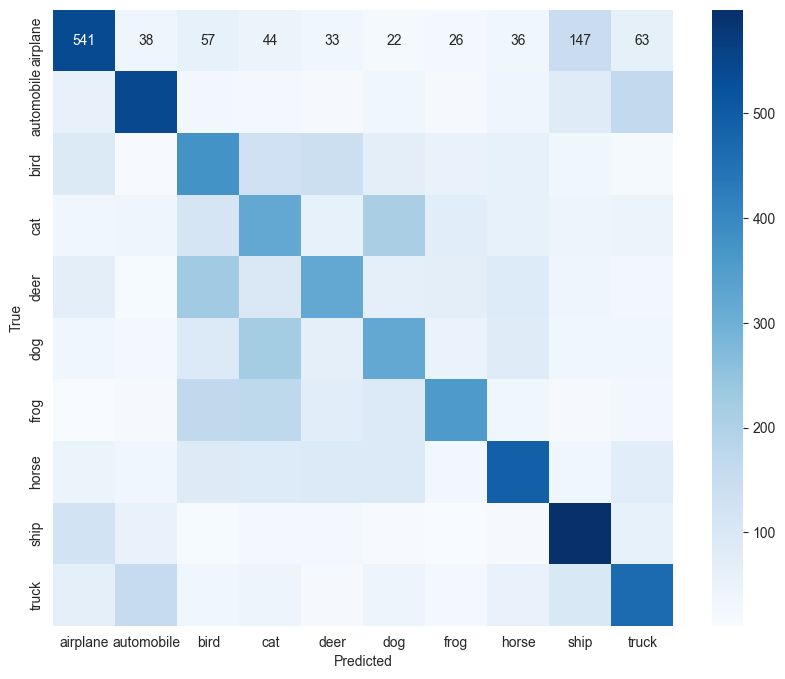

Best Epoch: 10


In [48]:
best_epoch = experiment_and_evaluate(
    model=model5,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

Add Batch Normalization performs worse (43%) than not adding Batch Normalization

In [49]:
# Layer Normalization
model6 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer')
# plot the model
model6.plot_model()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LayerNorm-2                 [-1, 2048]           4,096
             PReLU-3                 [-1, 2048]               1
            Linear-4                 [-1, 1024]       2,098,176
         LayerNorm-5                 [-1, 1024]           2,048
             PReLU-6                 [-1, 1024]               1
            Linear-7                  [-1, 512]         524,800
         LayerNorm-8                  [-1, 512]           1,024
             PReLU-9                  [-1, 512]               1
           Linear-10                  [-1, 128]          65,664
        LayerNorm-11                  [-1, 128]             256
            PReLU-12                  [-1, 128]               1
           Linear-13                   [-1, 10]           1,290
Total params: 8,990,862
Trainable param

In [50]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(model6.parameters(), lr=Hyperparams['learning_rate'], momentum=Hyperparams['momentum'])

Epoch 0/500, Train Loss: 1.8460, Train Acc: 0.3434, Val Loss: 1.7200, Val Acc: 0.3919
Epoch 1/500, Train Loss: 1.4958, Train Acc: 0.4751, Val Loss: 1.6503, Val Acc: 0.4169
Epoch 2/500, Train Loss: 1.2751, Train Acc: 0.5577, Val Loss: 1.6318, Val Acc: 0.4250
Epoch 3/500, Train Loss: 1.0197, Train Acc: 0.6640, Val Loss: 1.6725, Val Acc: 0.4342
Epoch 4/500, Train Loss: 0.7951, Train Acc: 0.7473, Val Loss: 1.7366, Val Acc: 0.4218
Epoch 5/500, Train Loss: 0.5722, Train Acc: 0.8369, Val Loss: 1.8339, Val Acc: 0.4163
Epoch 6/500, Train Loss: 0.4246, Train Acc: 0.8824, Val Loss: 1.8762, Val Acc: 0.4283
Epoch 7/500, Train Loss: 0.3237, Train Acc: 0.9140, Val Loss: 1.8894, Val Acc: 0.4509
Epoch 8/500, Train Loss: 0.2309, Train Acc: 0.9408, Val Loss: 2.0200, Val Acc: 0.4314
Epoch 9/500, Train Loss: 0.1688, Train Acc: 0.9580, Val Loss: 2.0526, Val Acc: 0.4436
Epoch 10/500, Train Loss: 0.1099, Train Acc: 0.9747, Val Loss: 2.1270, Val Acc: 0.4443
Epoch 11/500, Train Loss: 0.0901, Train Acc: 0.9785, 

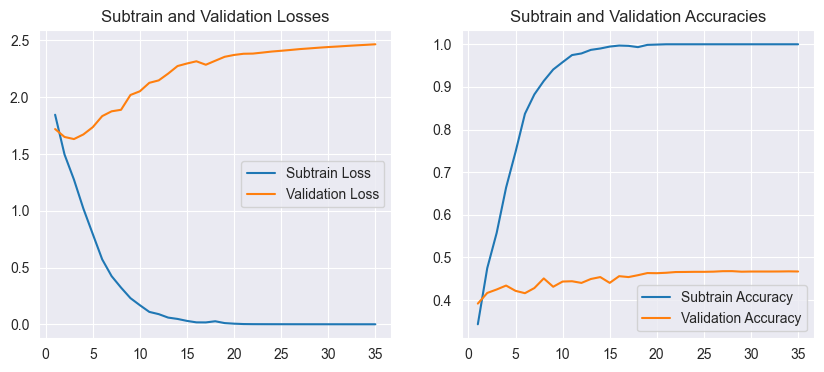

              precision    recall  f1-score   support

    airplane       0.53      0.54      0.53      1007
  automobile       0.54      0.59      0.56      1011
        bird       0.38      0.37      0.37       990
         cat       0.32      0.29      0.31      1002
        deer       0.40      0.39      0.40      1028
         dog       0.36      0.35      0.36       962
        frog       0.49      0.50      0.50       980
       horse       0.51      0.53      0.52      1065
        ship       0.58      0.63      0.60       946
       truck       0.51      0.49      0.50      1009

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000


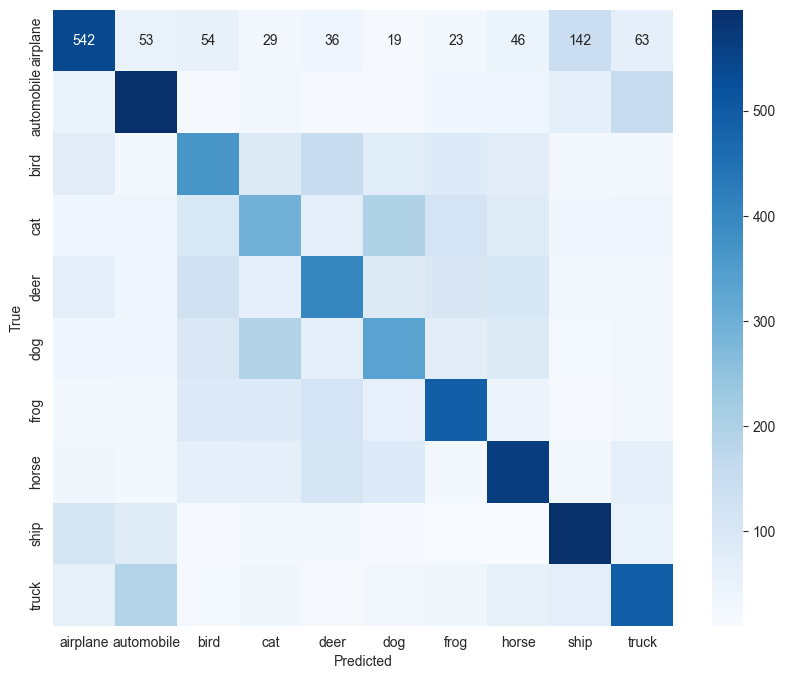

Best Epoch: 27


In [51]:
best_epoch = experiment_and_evaluate(
    model=model6,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 47% validation accuracy, Layer Normalization performs better than Batch Normalization. We will continue with Layer Normalization then.

### Experiment 5: We will be experimenting with regularization here

#### Experiment 5a: Weight decay. It will help reduce overfitting in the model.

In [72]:
# add weight decay
Hyperparams['weight_decay'] = 3e-8

In [75]:
model7 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer')
# plot the model
model7.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model7.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    weight_decay=Hyperparams['weight_decay'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LayerNorm-2                 [-1, 2048]           4,096
             PReLU-3                 [-1, 2048]               1
            Linear-4                 [-1, 1024]       2,098,176
         LayerNorm-5                 [-1, 1024]           2,048
             PReLU-6                 [-1, 1024]               1
            Linear-7                  [-1, 512]         524,800
         LayerNorm-8                  [-1, 512]           1,024
             PReLU-9                  [-1, 512]               1
           Linear-10                  [-1, 128]          65,664
        LayerNorm-11                  [-1, 128]             256
            PReLU-12                  [-1, 128]               1
           Linear-13                   [-1, 10]           1,290
Total params: 8,990,862
Trainable param

Epoch 0/500, Train Loss: 1.8532, Train Acc: 0.3461, Val Loss: 1.6989, Val Acc: 0.3992
Epoch 1/500, Train Loss: 1.4948, Train Acc: 0.4761, Val Loss: 1.6250, Val Acc: 0.4280
Epoch 2/500, Train Loss: 1.2604, Train Acc: 0.5704, Val Loss: 1.6136, Val Acc: 0.4299
Epoch 3/500, Train Loss: 1.0006, Train Acc: 0.6748, Val Loss: 1.6842, Val Acc: 0.4281
Epoch 4/500, Train Loss: 0.7967, Train Acc: 0.7483, Val Loss: 1.7395, Val Acc: 0.4355
Epoch 5/500, Train Loss: 0.5914, Train Acc: 0.8281, Val Loss: 1.8058, Val Acc: 0.4217
Epoch 6/500, Train Loss: 0.4054, Train Acc: 0.8897, Val Loss: 1.9555, Val Acc: 0.4194
Epoch 7/500, Train Loss: 0.3039, Train Acc: 0.9203, Val Loss: 1.9398, Val Acc: 0.4312
Epoch 8/500, Train Loss: 0.2180, Train Acc: 0.9436, Val Loss: 2.0973, Val Acc: 0.4352
Epoch 9/500, Train Loss: 0.1580, Train Acc: 0.9610, Val Loss: 2.1234, Val Acc: 0.4381
Epoch 10/500, Train Loss: 0.1405, Train Acc: 0.9675, Val Loss: 2.1728, Val Acc: 0.4258
Epoch 11/500, Train Loss: 0.1059, Train Acc: 0.9741, 

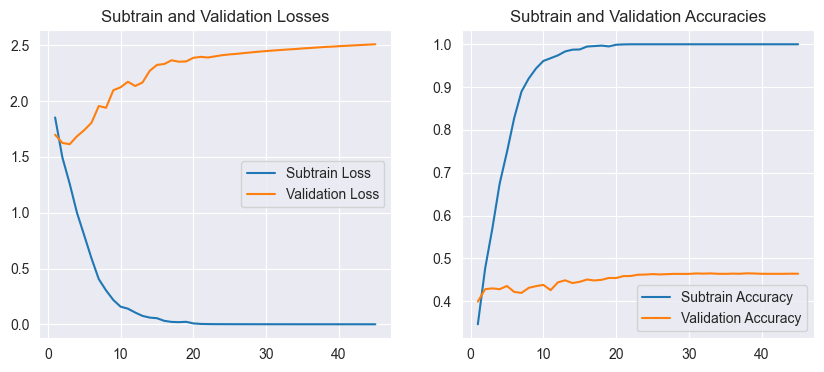

              precision    recall  f1-score   support

    airplane       0.52      0.54      0.53      1007
  automobile       0.54      0.60      0.57      1011
        bird       0.36      0.38      0.37       990
         cat       0.31      0.28      0.30      1002
        deer       0.40      0.37      0.38      1028
         dog       0.37      0.35      0.36       962
        frog       0.48      0.51      0.50       980
       horse       0.53      0.52      0.53      1065
        ship       0.58      0.60      0.59       946
       truck       0.50      0.48      0.49      1009

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000


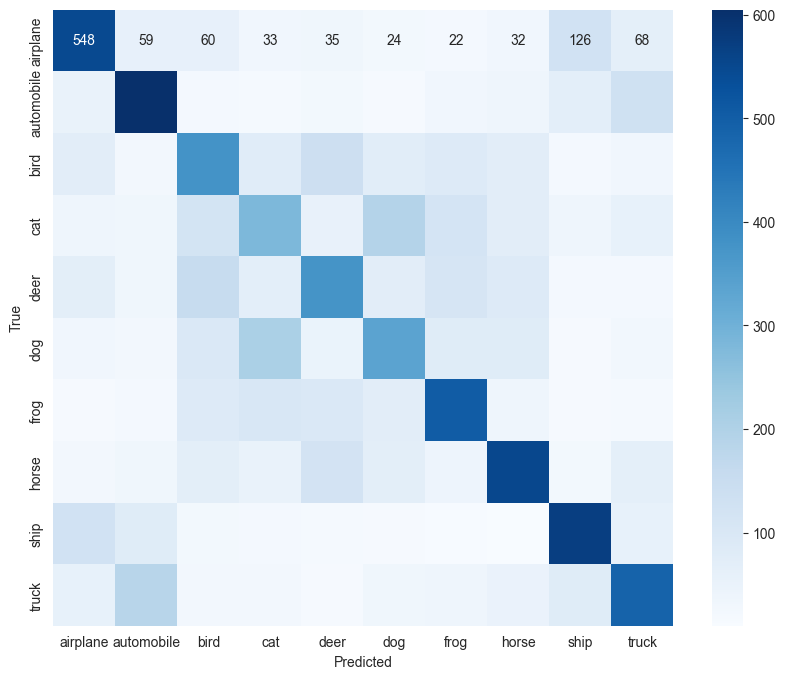

Best Epoch: 37


In [76]:
best_epoch = experiment_and_evaluate(
    model=model7,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 46% weight decay is not too bad. However, Early Stopping almost always does a better job at avoiding overfitting. Weight decay might be useful for
the final training run without early stopping. I am also noticing a pattern of overfitting when it comes to MLP on Cifar10. The subtraining accuracy is 100% while validation is 47% at best so far.

#### Experiment 5b: Dropout 
Dropout is another successful regularization technique. It helps to prevent overfitting in the model. We are experimenting with dropout here.

In [86]:
# dropout
model8 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer',
                    dropout=0.2)
# plot the model
model8.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model8.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    # weight_decay=Hyperparams['weight_decay'],
)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LayerNorm-2                 [-1, 2048]           4,096
             PReLU-3                 [-1, 2048]               1
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LayerNorm-6                 [-1, 1024]           2,048
             PReLU-7                 [-1, 1024]               1
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
        LayerNorm-10                  [-1, 512]           1,024
            PReLU-11                  [-1, 512]               1
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
        LayerNorm-14                  [

Epoch 0/500, Train Loss: 2.0495, Train Acc: 0.2763, Val Loss: 1.7570, Val Acc: 0.3786
Epoch 1/500, Train Loss: 1.7831, Train Acc: 0.3665, Val Loss: 1.7000, Val Acc: 0.4075
Epoch 2/500, Train Loss: 1.6682, Train Acc: 0.4073, Val Loss: 1.6388, Val Acc: 0.4195
Epoch 3/500, Train Loss: 1.5819, Train Acc: 0.4362, Val Loss: 1.6048, Val Acc: 0.4286
Epoch 4/500, Train Loss: 1.5220, Train Acc: 0.4622, Val Loss: 1.6089, Val Acc: 0.4326
Epoch 5/500, Train Loss: 1.4610, Train Acc: 0.4849, Val Loss: 1.6037, Val Acc: 0.4455
Epoch 6/500, Train Loss: 1.4050, Train Acc: 0.5049, Val Loss: 1.5702, Val Acc: 0.4585
Epoch 7/500, Train Loss: 1.3500, Train Acc: 0.5230, Val Loss: 1.5810, Val Acc: 0.4565
Epoch 8/500, Train Loss: 1.2902, Train Acc: 0.5465, Val Loss: 1.5898, Val Acc: 0.4583
Epoch 9/500, Train Loss: 1.2484, Train Acc: 0.5603, Val Loss: 1.6025, Val Acc: 0.4623
Epoch 10/500, Train Loss: 1.1838, Train Acc: 0.5815, Val Loss: 1.6274, Val Acc: 0.4670
Epoch 11/500, Train Loss: 1.1306, Train Acc: 0.6029, 

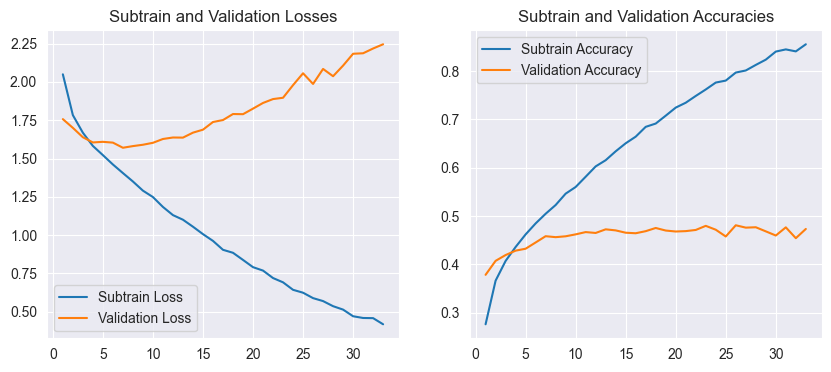

              precision    recall  f1-score   support

    airplane       0.51      0.57      0.54      1007
  automobile       0.57      0.61      0.59      1011
        bird       0.37      0.38      0.37       990
         cat       0.30      0.34      0.32      1002
        deer       0.42      0.39      0.40      1028
         dog       0.37      0.33      0.35       962
        frog       0.57      0.46      0.51       980
       horse       0.55      0.50      0.52      1065
        ship       0.62      0.57      0.59       946
       truck       0.50      0.57      0.54      1009

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.47     10000
weighted avg       0.48      0.47      0.47     10000


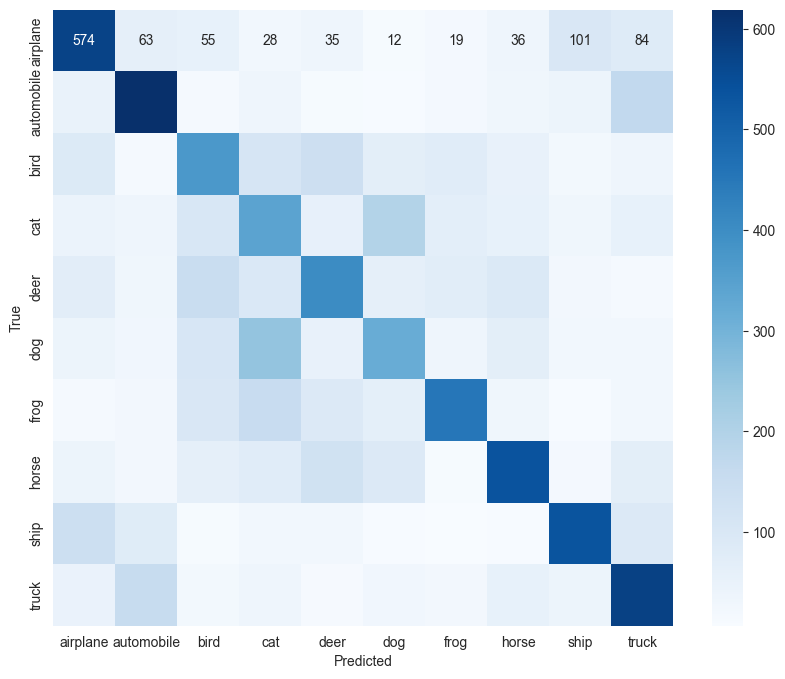

Best Epoch: 25


In [87]:
best_epoch = experiment_and_evaluate(
    model=model8,
    subtrain_loader=subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 47%, Dropout is offering a decent boost to the performance of our model.

#### Experiment 5c: Data augmentations
We are going to explore using data augmentations to train our model. The augmentations we are applying are fairly basic but will 
hopefully help the model be invariant to non-useful features in the image.

In [88]:
# Define the transform with augmentations
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Apply augmentations to the subtraining set
aug_subtrain_set = OneHotEncodedCIFAR10(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform))
aug_subtrain_set, aug_val_set, _ = data.random_split(aug_subtrain_set, [subtrain_len, validation_len, test_len])

# Apply augmentations to the training set
aug_training_set = data.ConcatDataset([aug_subtrain_set, aug_val_set])  # Reuse val_set from above

# Create augmented DataLoaders
aug_subtrain_loader = data.DataLoader(aug_subtrain_set, batch_size=Hyperparams['batch_size'], shuffle=True)
aug_train_loader = data.DataLoader(aug_training_set, batch_size=Hyperparams['batch_size'], shuffle=True)


Files already downloaded and verified


In [89]:
# dropout
model9 = Classifier(input_size,
                    num_classes,
                    [2048, 1024, 512, 128],
                    init_method='kaiming_normal',
                    activation_function=nn.PReLU(),
                    normalization='layer',
                    dropout=0.2)
# plot the model
model9.plot_model()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Instantiate the optimizer using the learning rate from Hyperparams
optimizer = optim.SGD(
    model9.parameters(),
    lr=Hyperparams['learning_rate'],
    momentum=Hyperparams['momentum'],
    # weight_decay=Hyperparams['weight_decay'],
)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
         LayerNorm-2                 [-1, 2048]           4,096
             PReLU-3                 [-1, 2048]               1
           Dropout-4                 [-1, 2048]               0
            Linear-5                 [-1, 1024]       2,098,176
         LayerNorm-6                 [-1, 1024]           2,048
             PReLU-7                 [-1, 1024]               1
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
        LayerNorm-10                  [-1, 512]           1,024
            PReLU-11                  [-1, 512]               1
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
        LayerNorm-14                  [

Epoch 0/500, Train Loss: 2.2272, Train Acc: 0.2032, Val Loss: 1.8930, Val Acc: 0.3339
Epoch 1/500, Train Loss: 2.0666, Train Acc: 0.2467, Val Loss: 1.8322, Val Acc: 0.3514
Epoch 2/500, Train Loss: 2.0248, Train Acc: 0.2527, Val Loss: 1.7959, Val Acc: 0.3604
Epoch 3/500, Train Loss: 2.0086, Train Acc: 0.2632, Val Loss: 1.7753, Val Acc: 0.3722
Epoch 4/500, Train Loss: 1.9662, Train Acc: 0.2804, Val Loss: 1.7442, Val Acc: 0.3867
Epoch 5/500, Train Loss: 1.9536, Train Acc: 0.2857, Val Loss: 1.7320, Val Acc: 0.3823
Epoch 6/500, Train Loss: 1.9426, Train Acc: 0.2903, Val Loss: 1.6918, Val Acc: 0.4027
Epoch 7/500, Train Loss: 1.9410, Train Acc: 0.2929, Val Loss: 1.7055, Val Acc: 0.3976
Epoch 8/500, Train Loss: 1.9149, Train Acc: 0.3022, Val Loss: 1.6942, Val Acc: 0.3933
Epoch 9/500, Train Loss: 1.9162, Train Acc: 0.2978, Val Loss: 1.6698, Val Acc: 0.4109
Epoch 10/500, Train Loss: 1.9168, Train Acc: 0.3021, Val Loss: 1.6629, Val Acc: 0.4056
Epoch 11/500, Train Loss: 1.9046, Train Acc: 0.3023, 

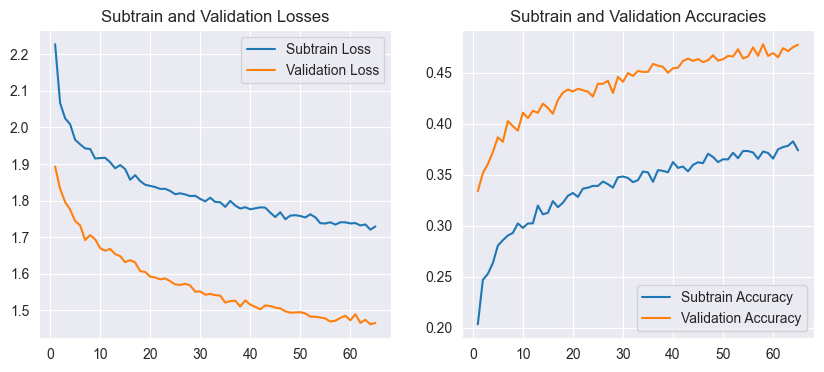

              precision    recall  f1-score   support

    airplane       0.54      0.54      0.54      1007
  automobile       0.50      0.66      0.57      1011
        bird       0.38      0.38      0.38       990
         cat       0.35      0.13      0.19      1002
        deer       0.45      0.42      0.43      1028
         dog       0.36      0.42      0.38       962
        frog       0.49      0.49      0.49       980
       horse       0.56      0.58      0.57      1065
        ship       0.65      0.60      0.62       946
       truck       0.45      0.57      0.50      1009

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000


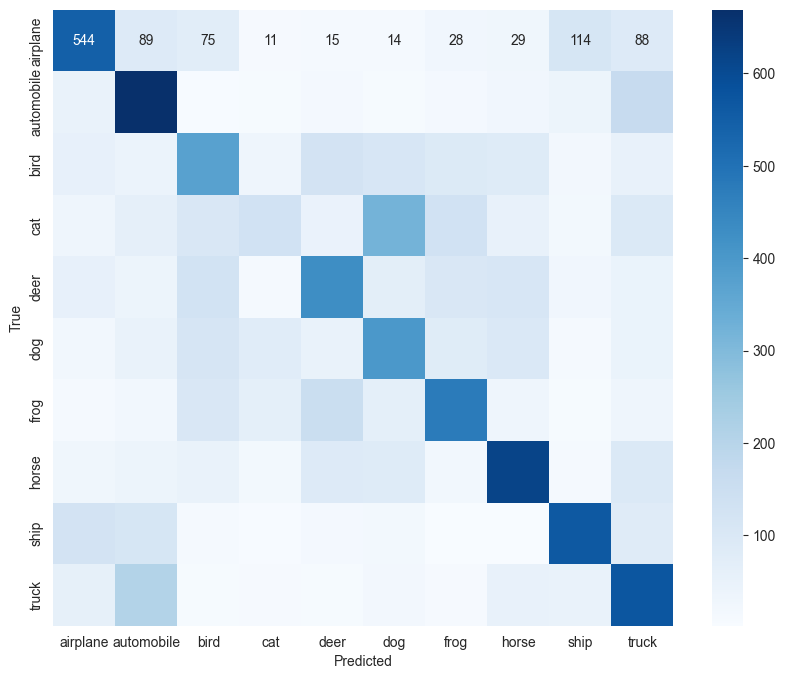

Best Epoch: 57


In [90]:
best_epoch = experiment_and_evaluate(
    model=model9,
    subtrain_loader=aug_subtrain_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    hyperparams=Hyperparams
)

At 48%, it seems that data augmentations do improve the performance of our model.

### Experiment 6: Ensembling the models

In [96]:
from Typing import List


class Ensemble(nn.Module):
    def __init__(self, models: List[nn.Module]):
        super(Ensemble, self).__init__()
        self.models = models

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output

Epoch 0/500, Train Loss: 2.2366, Train Acc: 0.1973, Val Loss: 1.8965, Val Acc: 0.3248
Epoch 1/500, Train Loss: 2.0806, Train Acc: 0.2354, Val Loss: 1.8340, Val Acc: 0.3456
Epoch 2/500, Train Loss: 2.0190, Train Acc: 0.2580, Val Loss: 1.8069, Val Acc: 0.3600
Epoch 3/500, Train Loss: 1.9920, Train Acc: 0.2673, Val Loss: 1.7831, Val Acc: 0.3640
Epoch 4/500, Train Loss: 1.9647, Train Acc: 0.2831, Val Loss: 1.7558, Val Acc: 0.3726
Epoch 5/500, Train Loss: 1.9644, Train Acc: 0.2857, Val Loss: 1.7428, Val Acc: 0.3719
Epoch 6/500, Train Loss: 1.9411, Train Acc: 0.2933, Val Loss: 1.7178, Val Acc: 0.3903
Epoch 7/500, Train Loss: 1.9382, Train Acc: 0.2915, Val Loss: 1.7184, Val Acc: 0.3913
Epoch 8/500, Train Loss: 1.9254, Train Acc: 0.2922, Val Loss: 1.7026, Val Acc: 0.3819
Epoch 9/500, Train Loss: 1.9113, Train Acc: 0.3000, Val Loss: 1.6833, Val Acc: 0.3903
Epoch 10/500, Train Loss: 1.9035, Train Acc: 0.3092, Val Loss: 1.6645, Val Acc: 0.4099
Epoch 11/500, Train Loss: 1.9009, Train Acc: 0.3053, 

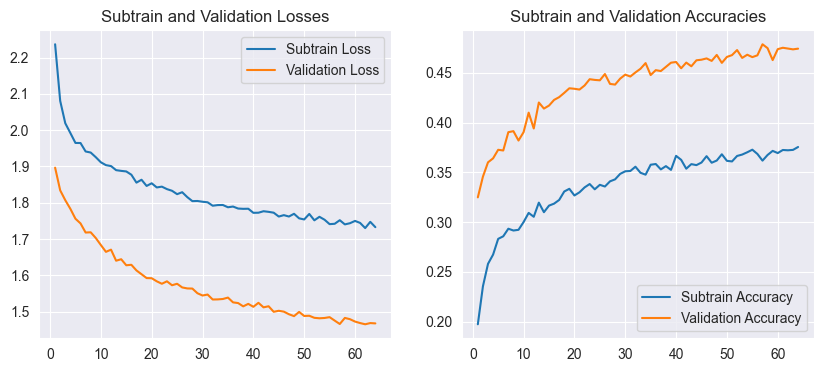

              precision    recall  f1-score   support

    airplane       0.53      0.53      0.53      1007
  automobile       0.55      0.61      0.58      1011
        bird       0.34      0.36      0.35       990
         cat       0.37      0.19      0.25      1002
        deer       0.47      0.34      0.39      1028
         dog       0.40      0.37      0.38       962
        frog       0.44      0.56      0.49       980
       horse       0.49      0.63      0.55      1065
        ship       0.58      0.66      0.61       946
       truck       0.50      0.50      0.50      1009

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000


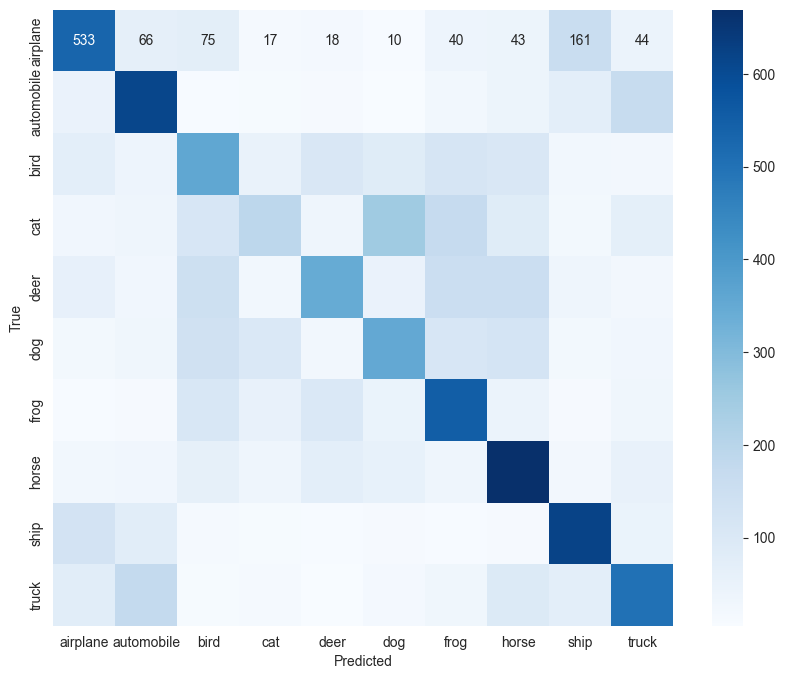

Best Epoch: 56
Epoch 0/500, Train Loss: 2.2190, Train Acc: 0.2033, Val Loss: 1.9044, Val Acc: 0.3174
Epoch 1/500, Train Loss: 2.0675, Train Acc: 0.2395, Val Loss: 1.8487, Val Acc: 0.3266
Epoch 2/500, Train Loss: 2.0277, Train Acc: 0.2536, Val Loss: 1.8021, Val Acc: 0.3527
Epoch 3/500, Train Loss: 1.9978, Train Acc: 0.2650, Val Loss: 1.7787, Val Acc: 0.3614
Epoch 4/500, Train Loss: 1.9798, Train Acc: 0.2714, Val Loss: 1.7455, Val Acc: 0.3755
Epoch 5/500, Train Loss: 1.9614, Train Acc: 0.2910, Val Loss: 1.7243, Val Acc: 0.3887
Epoch 6/500, Train Loss: 1.9380, Train Acc: 0.2887, Val Loss: 1.7098, Val Acc: 0.3866
Epoch 7/500, Train Loss: 1.9344, Train Acc: 0.2888, Val Loss: 1.6990, Val Acc: 0.3946
Epoch 8/500, Train Loss: 1.9278, Train Acc: 0.3007, Val Loss: 1.6754, Val Acc: 0.4061
Epoch 9/500, Train Loss: 1.9147, Train Acc: 0.3042, Val Loss: 1.6690, Val Acc: 0.4102
Epoch 10/500, Train Loss: 1.9012, Train Acc: 0.3071, Val Loss: 1.6679, Val Acc: 0.4087
Epoch 11/500, Train Loss: 1.8956, Trai

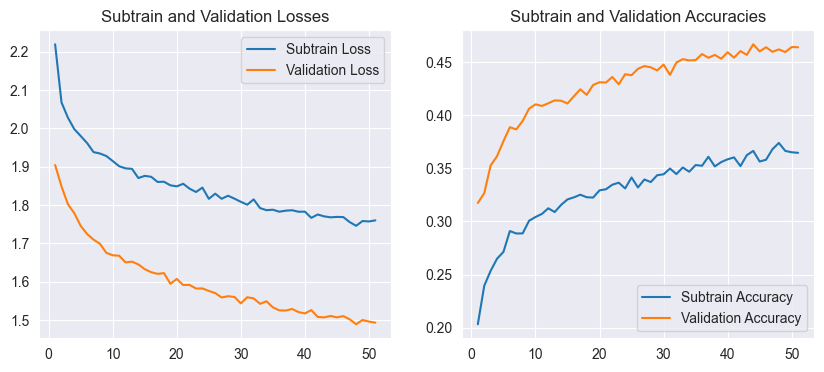

              precision    recall  f1-score   support

    airplane       0.49      0.57      0.52      1007
  automobile       0.57      0.60      0.59      1011
        bird       0.37      0.27      0.31       990
         cat       0.37      0.14      0.20      1002
        deer       0.44      0.38      0.41      1028
         dog       0.36      0.40      0.38       962
        frog       0.43      0.55      0.49       980
       horse       0.48      0.59      0.53      1065
        ship       0.51      0.71      0.59       946
       truck       0.52      0.45      0.48      1009

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000


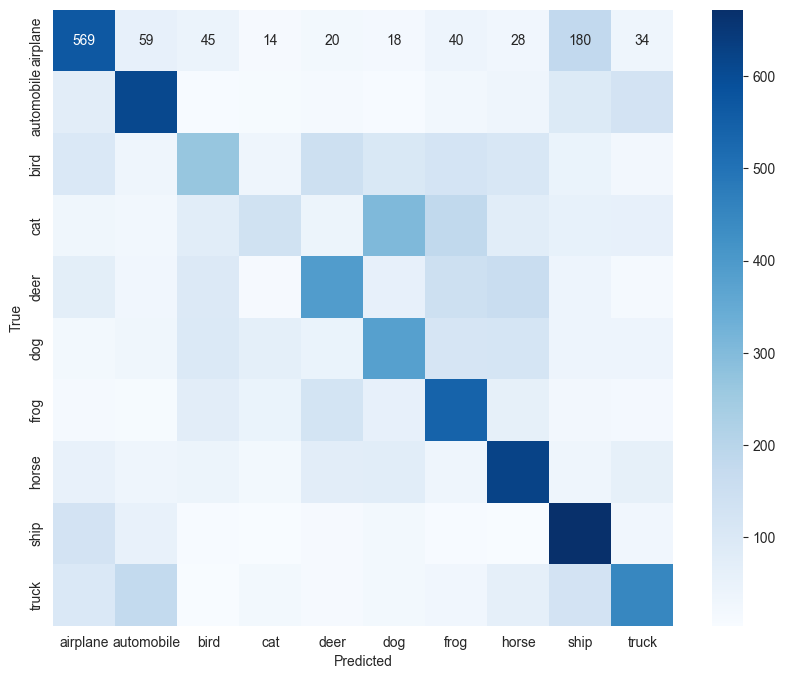

Best Epoch: 43
Epoch 0/500, Train Loss: 2.2102, Train Acc: 0.2044, Val Loss: 1.9071, Val Acc: 0.3265
Epoch 1/500, Train Loss: 2.0566, Train Acc: 0.2467, Val Loss: 1.8498, Val Acc: 0.3359
Epoch 2/500, Train Loss: 2.0293, Train Acc: 0.2524, Val Loss: 1.8169, Val Acc: 0.3546
Epoch 3/500, Train Loss: 1.9930, Train Acc: 0.2657, Val Loss: 1.7806, Val Acc: 0.3668
Epoch 4/500, Train Loss: 1.9751, Train Acc: 0.2720, Val Loss: 1.7690, Val Acc: 0.3678
Epoch 5/500, Train Loss: 1.9546, Train Acc: 0.2827, Val Loss: 1.7408, Val Acc: 0.3729
Epoch 6/500, Train Loss: 1.9452, Train Acc: 0.2835, Val Loss: 1.7110, Val Acc: 0.3914
Epoch 7/500, Train Loss: 1.9323, Train Acc: 0.2934, Val Loss: 1.7167, Val Acc: 0.3861
Epoch 8/500, Train Loss: 1.9224, Train Acc: 0.2973, Val Loss: 1.7038, Val Acc: 0.3918
Epoch 9/500, Train Loss: 1.9177, Train Acc: 0.3050, Val Loss: 1.6879, Val Acc: 0.3949
Epoch 10/500, Train Loss: 1.9019, Train Acc: 0.3164, Val Loss: 1.6748, Val Acc: 0.4034
Epoch 11/500, Train Loss: 1.8946, Trai

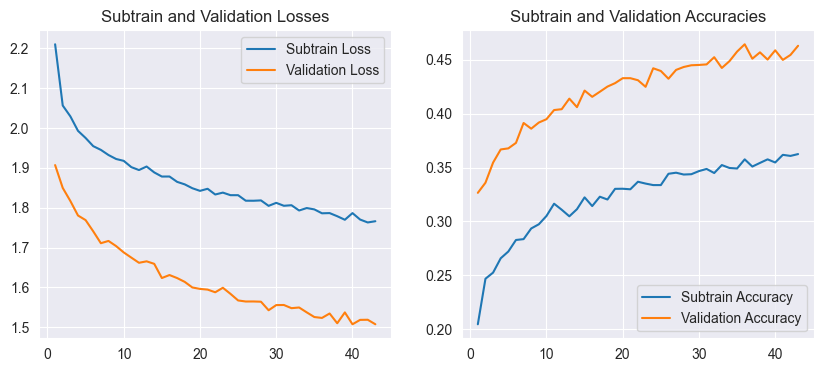

              precision    recall  f1-score   support

    airplane       0.47      0.57      0.52      1007
  automobile       0.52      0.63      0.57      1011
        bird       0.36      0.32      0.34       990
         cat       0.36      0.21      0.27      1002
        deer       0.41      0.37      0.39      1028
         dog       0.43      0.30      0.35       962
        frog       0.43      0.52      0.47       980
       horse       0.49      0.58      0.53      1065
        ship       0.57      0.64      0.60       946
       truck       0.49      0.49      0.49      1009

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000


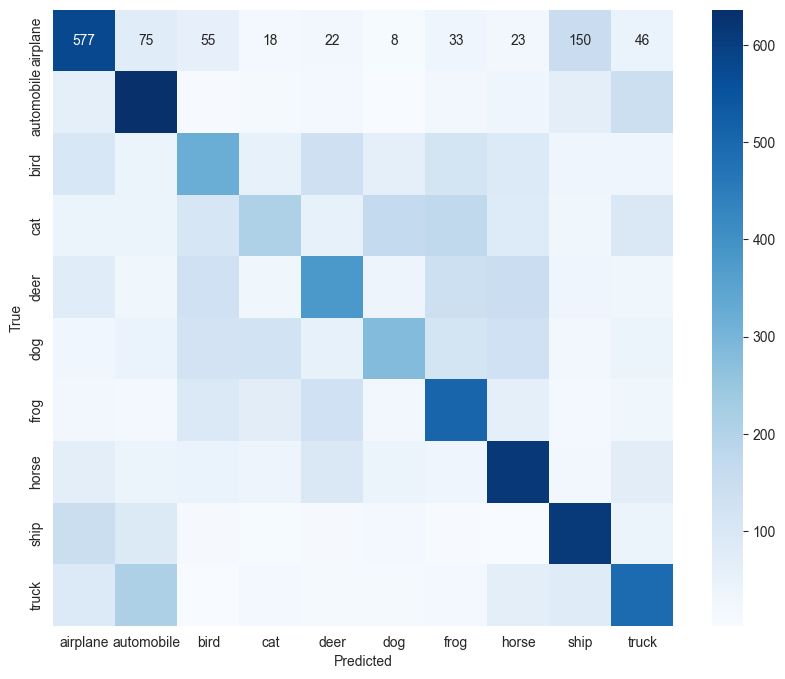

Best Epoch: 35


In [97]:
ensemble_size = 3
experts = []
for _ in range(ensemble_size):
    expert = Classifier(input_size,
                        num_classes,
                        [2048, 1024, 512, 128],
                        init_method='kaiming_normal',
                        activation_function=nn.PReLU(),
                        normalization='layer',
                        dropout=0.2)
    # plot the model
    # expert.plot_model()
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Instantiate the optimizer using the learning rate from Hyperparams
    optimizer = optim.SGD(
        expert.parameters(),
        lr=Hyperparams['learning_rate'],
        momentum=Hyperparams['momentum'],
        # weight_decay=Hyperparams['weight_decay'],
    )

    best_epoch = experiment_and_evaluate(
        model=expert,
        subtrain_loader=aug_subtrain_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    experts.append(expert)

              precision    recall  f1-score   support

    airplane       0.49      0.57      0.53      1007
  automobile       0.56      0.62      0.59      1011
        bird       0.35      0.31      0.33       990
         cat       0.37      0.18      0.24      1002
        deer       0.45      0.36      0.40      1028
         dog       0.39      0.35      0.37       962
        frog       0.44      0.55      0.49       980
       horse       0.49      0.60      0.54      1065
        ship       0.55      0.67      0.60       946
       truck       0.51      0.49      0.50      1009

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000


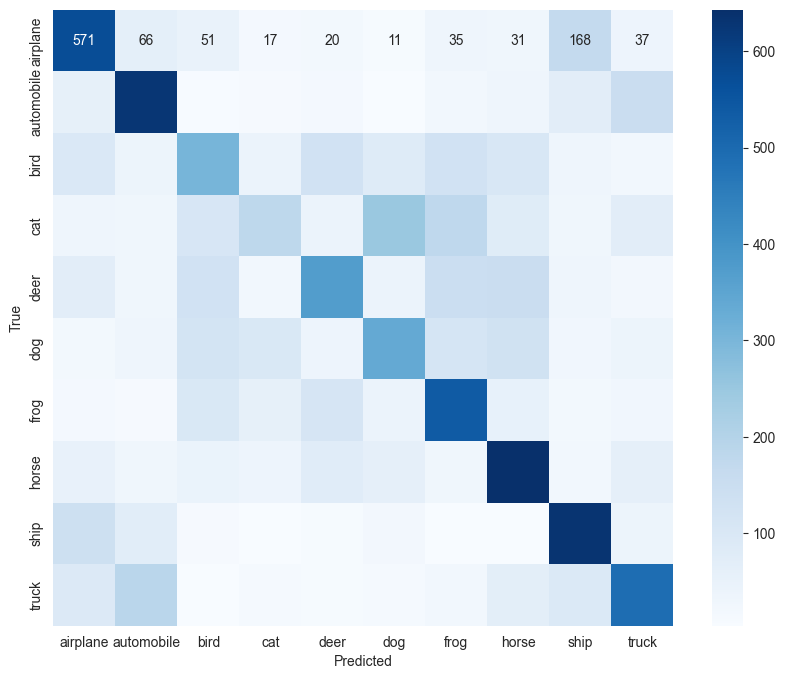

In [98]:
ensemble_model = Ensemble(experts)
evaluate_and_plot(ensemble_model, val_loader)

# let's put all our learnings from the experiments together and see what kind of performance we can achieve.

Epoch 0/500, Train Loss: 2.1057, Train Acc: 0.2318, Val Loss: 1.8089, Val Acc: 0.3595
Epoch 1/500, Train Loss: 1.9736, Train Acc: 0.2738, Val Loss: 1.7367, Val Acc: 0.3852
Epoch 2/500, Train Loss: 1.9373, Train Acc: 0.2919, Val Loss: 1.6985, Val Acc: 0.4016
Epoch 3/500, Train Loss: 1.9101, Train Acc: 0.3013, Val Loss: 1.6720, Val Acc: 0.4057
Epoch 4/500, Train Loss: 1.8859, Train Acc: 0.3140, Val Loss: 1.6366, Val Acc: 0.4241
Epoch 5/500, Train Loss: 1.8683, Train Acc: 0.3197, Val Loss: 1.6162, Val Acc: 0.4243
Epoch 6/500, Train Loss: 1.8560, Train Acc: 0.3247, Val Loss: 1.5922, Val Acc: 0.4320
Epoch 7/500, Train Loss: 1.8414, Train Acc: 0.3297, Val Loss: 1.5692, Val Acc: 0.4455
Epoch 8/500, Train Loss: 1.8381, Train Acc: 0.3348, Val Loss: 1.5596, Val Acc: 0.4449
Epoch 9/500, Train Loss: 1.8237, Train Acc: 0.3374, Val Loss: 1.5758, Val Acc: 0.4433
Epoch 10/500, Train Loss: 1.8129, Train Acc: 0.3437, Val Loss: 1.5397, Val Acc: 0.4500
Epoch 11/500, Train Loss: 1.8014, Train Acc: 0.3470, 

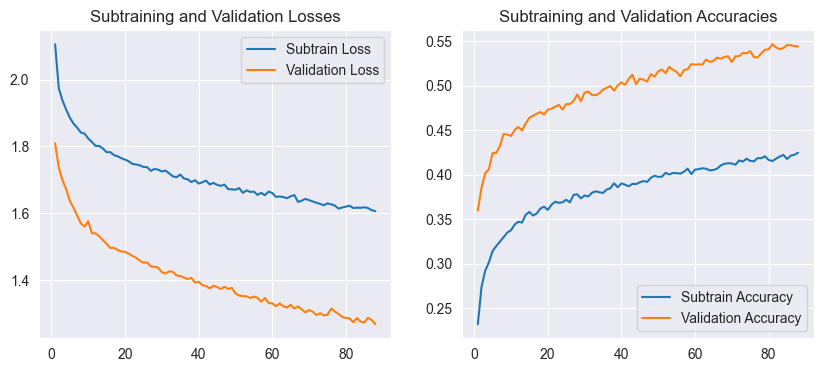

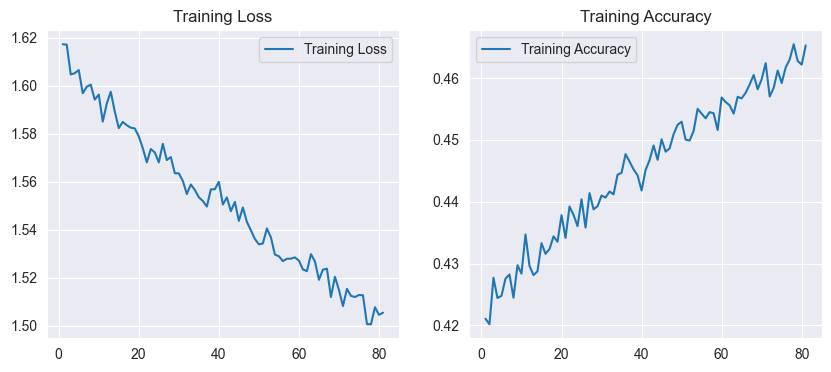

Best Epoch: 80
Training Runtime: 2399.85 seconds
Epoch 0/500, Train Loss: 2.1080, Train Acc: 0.2299, Val Loss: 1.8124, Val Acc: 0.3484
Epoch 1/500, Train Loss: 1.9754, Train Acc: 0.2716, Val Loss: 1.7424, Val Acc: 0.3815
Epoch 2/500, Train Loss: 1.9345, Train Acc: 0.2947, Val Loss: 1.6917, Val Acc: 0.3986
Epoch 3/500, Train Loss: 1.9146, Train Acc: 0.2962, Val Loss: 1.6714, Val Acc: 0.4038
Epoch 4/500, Train Loss: 1.8905, Train Acc: 0.3128, Val Loss: 1.6448, Val Acc: 0.4112
Epoch 5/500, Train Loss: 1.8748, Train Acc: 0.3175, Val Loss: 1.6148, Val Acc: 0.4240
Epoch 6/500, Train Loss: 1.8553, Train Acc: 0.3217, Val Loss: 1.6017, Val Acc: 0.4278
Epoch 7/500, Train Loss: 1.8415, Train Acc: 0.3310, Val Loss: 1.5898, Val Acc: 0.4329
Epoch 8/500, Train Loss: 1.8317, Train Acc: 0.3380, Val Loss: 1.5662, Val Acc: 0.4439
Epoch 9/500, Train Loss: 1.8254, Train Acc: 0.3374, Val Loss: 1.5548, Val Acc: 0.4509
Epoch 10/500, Train Loss: 1.8152, Train Acc: 0.3408, Val Loss: 1.5464, Val Acc: 0.4510
Epoc

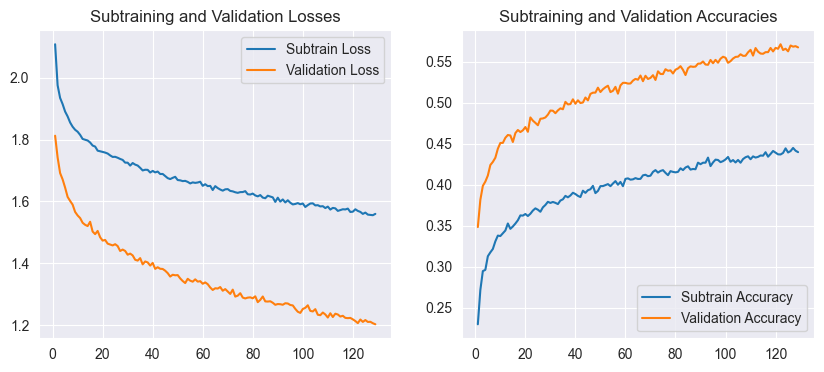

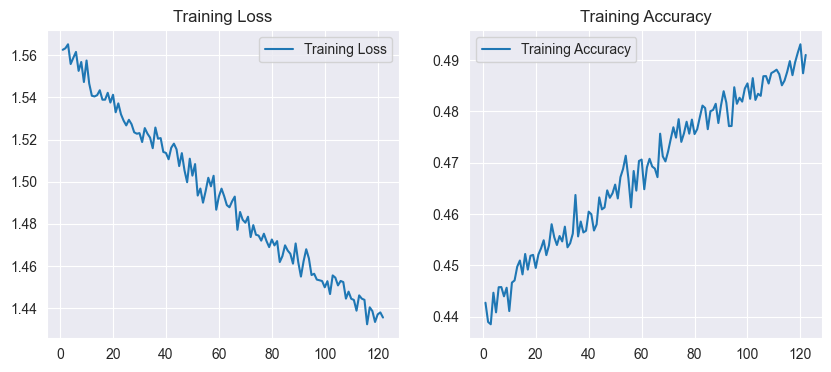

Best Epoch: 121
Training Runtime: 3612.49 seconds
Epoch 0/500, Train Loss: 2.1053, Train Acc: 0.2310, Val Loss: 1.8230, Val Acc: 0.3524
Epoch 1/500, Train Loss: 1.9804, Train Acc: 0.2741, Val Loss: 1.7692, Val Acc: 0.3755
Epoch 2/500, Train Loss: 1.9435, Train Acc: 0.2904, Val Loss: 1.7046, Val Acc: 0.4004
Epoch 3/500, Train Loss: 1.9142, Train Acc: 0.3004, Val Loss: 1.6753, Val Acc: 0.4063
Epoch 4/500, Train Loss: 1.8908, Train Acc: 0.3093, Val Loss: 1.6355, Val Acc: 0.4238
Epoch 5/500, Train Loss: 1.8692, Train Acc: 0.3179, Val Loss: 1.6231, Val Acc: 0.4199
Epoch 6/500, Train Loss: 1.8639, Train Acc: 0.3247, Val Loss: 1.6060, Val Acc: 0.4292
Epoch 7/500, Train Loss: 1.8420, Train Acc: 0.3302, Val Loss: 1.5824, Val Acc: 0.4331
Epoch 8/500, Train Loss: 1.8347, Train Acc: 0.3340, Val Loss: 1.5653, Val Acc: 0.4432
Epoch 9/500, Train Loss: 1.8289, Train Acc: 0.3342, Val Loss: 1.5737, Val Acc: 0.4420
Epoch 10/500, Train Loss: 1.8121, Train Acc: 0.3411, Val Loss: 1.5434, Val Acc: 0.4477
Epo

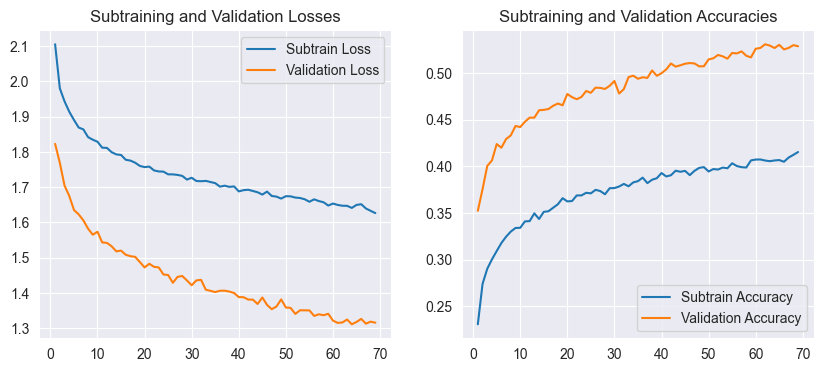

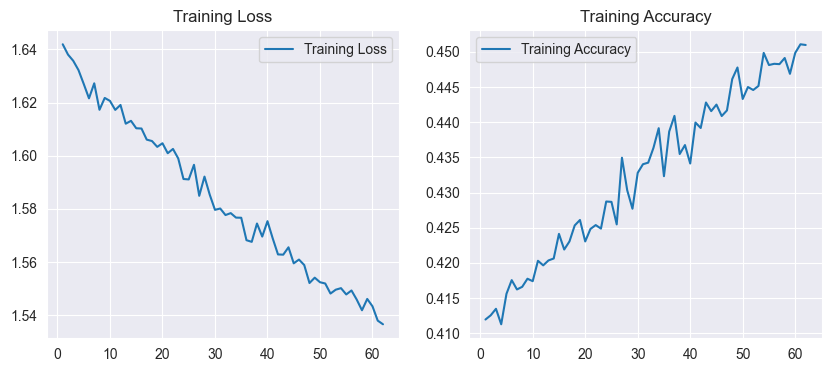

Best Epoch: 61
Training Runtime: 1927.34 seconds


In [101]:
ensemble_size = 3
experts = []

for _ in range(ensemble_size):
    expert = Classifier(input_size,
                        num_classes,
                        [2048, 1024, 512, 128],
                        init_method='kaiming_normal',
                        activation_function=nn.PReLU(),
                        normalization='layer',
                        dropout=0.2)
    # plot the model
    # expert.plot_model()
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Instantiate the optimizer using the learning rate from Hyperparams
    optimizer = optim.SGD(
        expert.parameters(),
        lr=Hyperparams['learning_rate'],
        momentum=Hyperparams['momentum'],
        weight_decay=Hyperparams['weight_decay'],
    )

    best_epoch, training_runtime = train_and_evaluate(
        model=expert,
        subtrain_loader=aug_subtrain_loader,
        train_loader=aug_train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    experts.append(expert)

              precision    recall  f1-score   support

    airplane       0.65      0.70      0.67       999
  automobile       0.67      0.75      0.70       988
        bird       0.53      0.44      0.48      1002
         cat       0.50      0.25      0.33      1059
        deer       0.53      0.54      0.54       931
         dog       0.52      0.53      0.52      1032
        frog       0.62      0.72      0.67      1049
       horse       0.65      0.72      0.69       960
        ship       0.73      0.78      0.75       986
       truck       0.61      0.67      0.64       994

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.60      0.61      0.60     10000


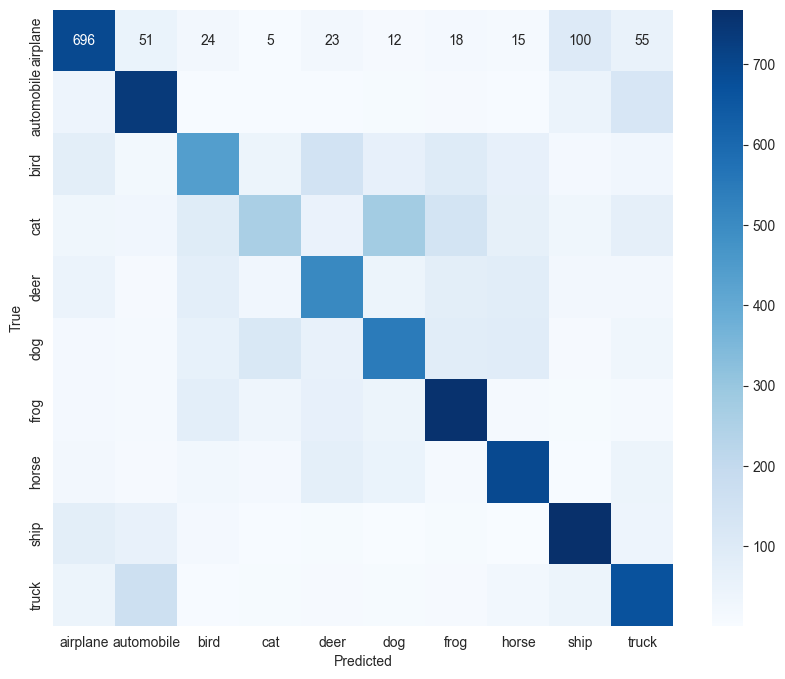

In [102]:
ensemble_model = Ensemble(experts)
evaluate_and_plot(ensemble_model, test_loader)

We get 61% accuracy here

### Let's try with Adam Optimizer now

Epoch 0/500, Train Loss: 2.0915, Train Acc: 0.2235, Val Loss: 1.8776, Val Acc: 0.3170
Epoch 1/500, Train Loss: 1.9705, Train Acc: 0.2724, Val Loss: 1.7939, Val Acc: 0.3523
Epoch 2/500, Train Loss: 1.9254, Train Acc: 0.2958, Val Loss: 1.7202, Val Acc: 0.3883
Epoch 3/500, Train Loss: 1.8822, Train Acc: 0.3143, Val Loss: 1.7032, Val Acc: 0.3857
Epoch 4/500, Train Loss: 1.8592, Train Acc: 0.3208, Val Loss: 1.6701, Val Acc: 0.4143
Epoch 5/500, Train Loss: 1.8405, Train Acc: 0.3255, Val Loss: 1.6214, Val Acc: 0.4248
Epoch 6/500, Train Loss: 1.8161, Train Acc: 0.3416, Val Loss: 1.5943, Val Acc: 0.4321
Epoch 7/500, Train Loss: 1.8132, Train Acc: 0.3433, Val Loss: 1.5787, Val Acc: 0.4293
Epoch 8/500, Train Loss: 1.7981, Train Acc: 0.3477, Val Loss: 1.5887, Val Acc: 0.4360
Epoch 9/500, Train Loss: 1.7899, Train Acc: 0.3525, Val Loss: 1.5858, Val Acc: 0.4406
Epoch 10/500, Train Loss: 1.7710, Train Acc: 0.3623, Val Loss: 1.5263, Val Acc: 0.4579
Epoch 11/500, Train Loss: 1.7674, Train Acc: 0.3626, 

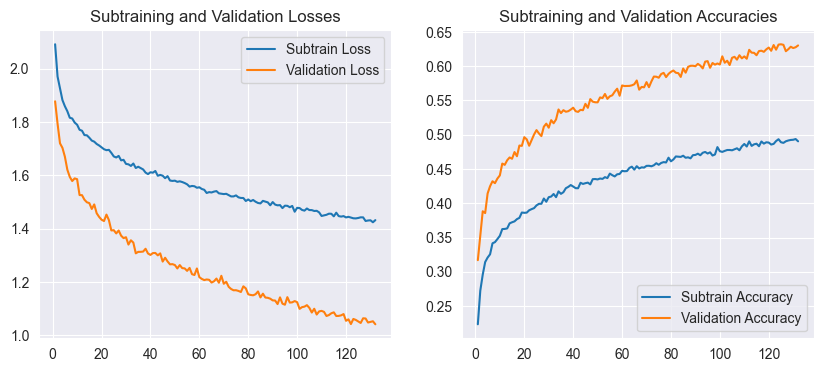

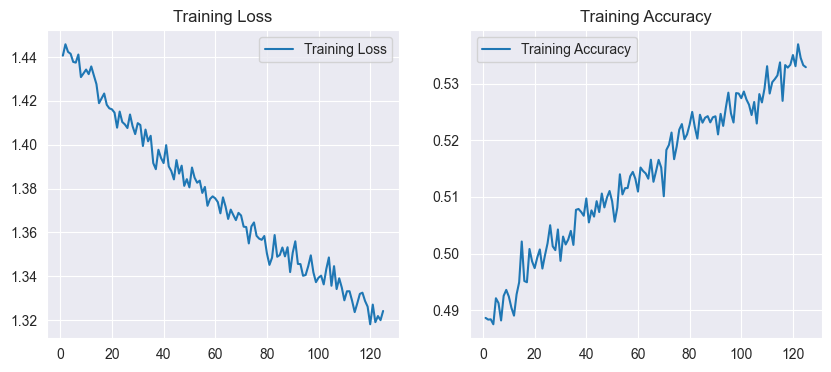

Best Epoch: 124
Training Runtime: 4083.71 seconds
Epoch 0/500, Train Loss: 2.0942, Train Acc: 0.2207, Val Loss: 1.8958, Val Acc: 0.3067
Epoch 1/500, Train Loss: 1.9711, Train Acc: 0.2740, Val Loss: 1.7924, Val Acc: 0.3652
Epoch 2/500, Train Loss: 1.9261, Train Acc: 0.2976, Val Loss: 1.7360, Val Acc: 0.3847
Epoch 3/500, Train Loss: 1.8857, Train Acc: 0.3135, Val Loss: 1.6861, Val Acc: 0.4026
Epoch 4/500, Train Loss: 1.8608, Train Acc: 0.3225, Val Loss: 1.6594, Val Acc: 0.4021
Epoch 5/500, Train Loss: 1.8415, Train Acc: 0.3321, Val Loss: 1.6445, Val Acc: 0.4159
Epoch 6/500, Train Loss: 1.8225, Train Acc: 0.3424, Val Loss: 1.5952, Val Acc: 0.4307
Epoch 7/500, Train Loss: 1.8134, Train Acc: 0.3424, Val Loss: 1.5921, Val Acc: 0.4257
Epoch 8/500, Train Loss: 1.7972, Train Acc: 0.3478, Val Loss: 1.5410, Val Acc: 0.4479
Epoch 9/500, Train Loss: 1.7869, Train Acc: 0.3518, Val Loss: 1.5729, Val Acc: 0.4398
Epoch 10/500, Train Loss: 1.7758, Train Acc: 0.3596, Val Loss: 1.5460, Val Acc: 0.4507
Epo

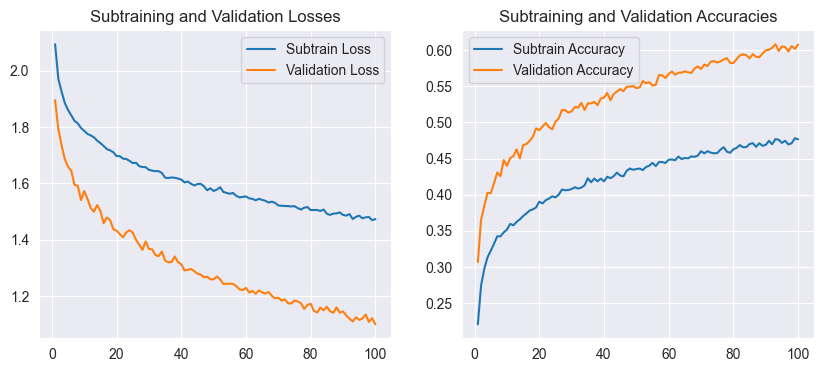

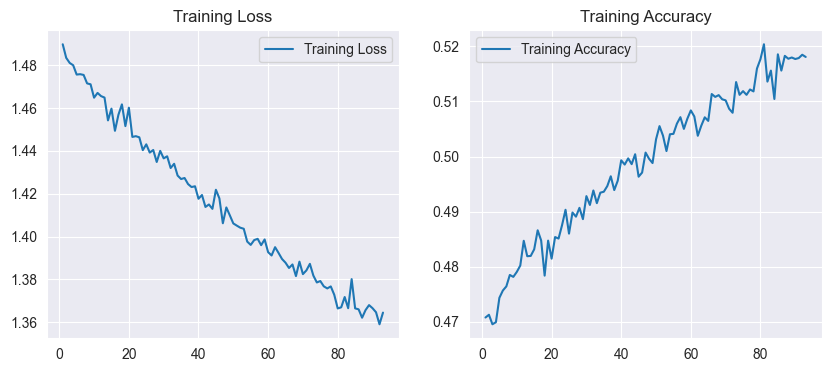

Best Epoch: 92
Training Runtime: 3056.83 seconds
Epoch 0/500, Train Loss: 2.1016, Train Acc: 0.2202, Val Loss: 1.8884, Val Acc: 0.3315
Epoch 1/500, Train Loss: 1.9727, Train Acc: 0.2681, Val Loss: 1.7700, Val Acc: 0.3749
Epoch 2/500, Train Loss: 1.9290, Train Acc: 0.2946, Val Loss: 1.7324, Val Acc: 0.3815
Epoch 3/500, Train Loss: 1.8893, Train Acc: 0.3096, Val Loss: 1.6818, Val Acc: 0.3962
Epoch 4/500, Train Loss: 1.8630, Train Acc: 0.3216, Val Loss: 1.6288, Val Acc: 0.4209
Epoch 5/500, Train Loss: 1.8376, Train Acc: 0.3307, Val Loss: 1.5886, Val Acc: 0.4374
Epoch 6/500, Train Loss: 1.8218, Train Acc: 0.3406, Val Loss: 1.5988, Val Acc: 0.4277
Epoch 7/500, Train Loss: 1.8041, Train Acc: 0.3479, Val Loss: 1.5747, Val Acc: 0.4350
Epoch 8/500, Train Loss: 1.7946, Train Acc: 0.3501, Val Loss: 1.5929, Val Acc: 0.4411
Epoch 9/500, Train Loss: 1.7862, Train Acc: 0.3539, Val Loss: 1.5519, Val Acc: 0.4392
Epoch 10/500, Train Loss: 1.7758, Train Acc: 0.3585, Val Loss: 1.5510, Val Acc: 0.4384
Epoc

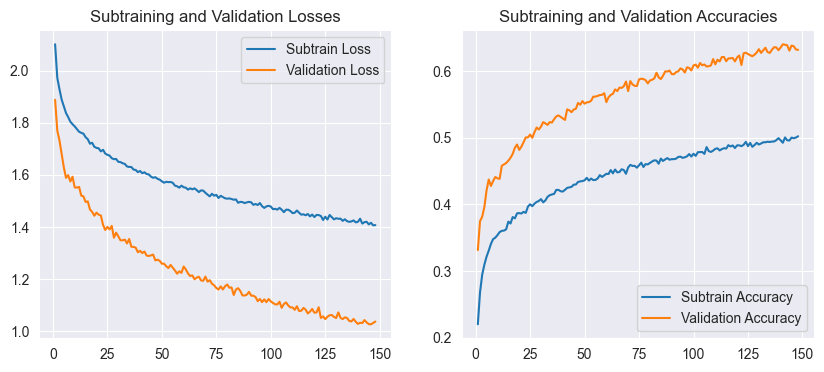

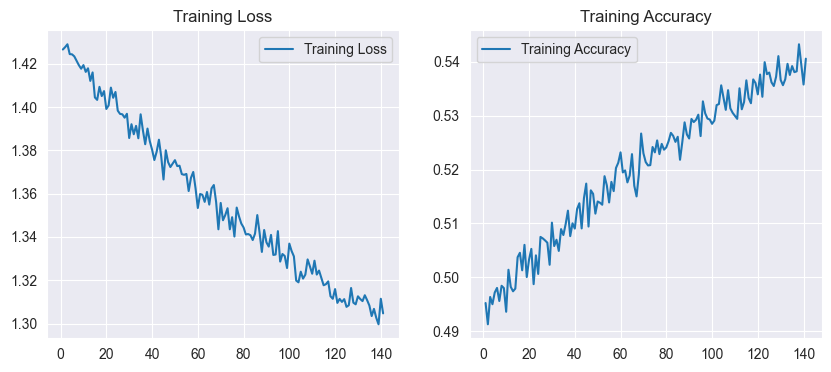

Best Epoch: 140
Training Runtime: 4640.66 seconds


In [99]:
ensemble_size = 3
adam_experts = []

for _ in range(ensemble_size):
    expert = Classifier(input_size,
                        num_classes,
                        [2048, 1024, 512, 128],
                        init_method='kaiming_normal',
                        activation_function=nn.PReLU(),
                        normalization='layer',
                        dropout=0.2)
    # plot the model
    # expert.plot_model()
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Instantiate the optimizer using the learning rate from Hyperparams
    optimizer = optim.Adam(
        expert.parameters(),
        lr=Hyperparams['learning_rate'],
        weight_decay=Hyperparams['weight_decay'])

    best_epoch, training_runtime = train_and_evaluate(
        model=expert,
        subtrain_loader=aug_subtrain_loader,
        train_loader=aug_train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        hyperparams=Hyperparams
    )

    adam_experts.append(expert)

              precision    recall  f1-score   support

    airplane       0.75      0.79      0.77       999
  automobile       0.78      0.79      0.79       988
        bird       0.65      0.61      0.63      1002
         cat       0.64      0.40      0.49      1059
        deer       0.63      0.66      0.64       931
         dog       0.60      0.62      0.61      1032
        frog       0.71      0.78      0.74      1049
       horse       0.75      0.79      0.77       960
        ship       0.82      0.82      0.82       986
       truck       0.70      0.80      0.75       994

    accuracy                           0.70     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.70      0.70     10000


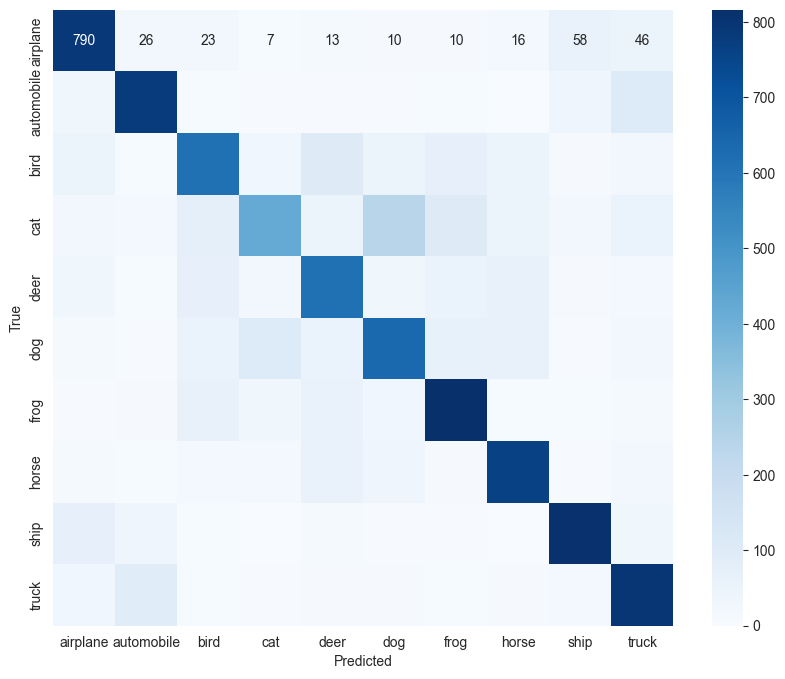

In [100]:
adam_ensemble_model = Ensemble(adam_experts)
evaluate_and_plot(adam_ensemble_model, test_loader)

We are able to achieve 70% accuracy on the test set with all the tricks we have experimented with put together. 